# "Concevez une application au service de la santé publique"
_Cleaning Notebook_

## 0 Preliminaries

### 0.0 Importing Packages and Modules

In [95]:
import sys

# Checking whether the notebook is on Colab or PC

is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

In [96]:
# Installations and importations required for Google Colab version

if is_colab==True:
    from google.colab import files, output
    !pip install python-stdnum
    !pip install gTTS
    !pip install ipywidgets
    !pip install simplejson
else:
    # make sure 'requirements.txt' is in the current working directory
    !pip install -r requirements.txt

In [0]:
## IMPORTATIONS

import os
import io
import re
import simplejson as json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
from stdnum.ean import *
from ipywidgets import interact, interact_manual
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.dummy import DummyClassifier
import missingno as msno

In [0]:
# Function to display small dataframes side by side

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),
                 raw=True)

In [0]:
# Setting pandas display options

dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 20,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

In [0]:
# To play audio text-to-speech during execution

from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [101]:
speak('Packages and modules successfully imported')

### 0.1 Importing a sample of the dataset

In order to facilitate further manipulation of the dataset, we only upload a sample of the dataset at fisrt.

This will allow us to determine the best encoding form for each column therefore resulting in a better optimization of memory usage while uploading the full dataset.

In [102]:
p = 0.005  # reads 0.5% of the lines

if is_colab==True:
    path_csv = '/content/en.openfoodfacts.org.products.csv'
    if not os.path.exists(path_csv):
        print("1. Try to download in Colab env from the internet ...")
        # Importing database from the Internet if not already in Colab env.
        !wget https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv
        print("...Downloaded from the Internet OK")
    else:
        # Importing database from a the Colab env 'content' directory
        print("2. Try to import in notebook from Colab environment...")
else:
    if not os.path.exists('../DATA'):
        os.makedirs('../DATA')
    # Importing database from the Internet if not already in PC
    path_csv = '../DATA/en.openfoodfacts.org.products.csv'
    if not os.path.exists(path_csv):
        print("1. Try to download on PC ('../DATA') from the internet ...")
        !os.chdir('../DATA')
        !wget https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv
        print("...Downloaded from the Internet OK")
    else:
        # Importing database from a DATA directory
        print("2. Try to import in notebook from PC ('../DATA')")

df = pd.read_csv(path_csv, header=0, sep='\t',
                 low_memory=False, encoding ='utf-8',
                 skiprows=lambda i: i>0 and np.random.random() > p)
print("-----> importation of .csv file in notebook OK")

2. Try to import in notebook from Colab environment...
-----> importation of .csv file in notebook OK


In [103]:
speak('Dataset successfully imported')

### 0.2 Memory usage reduction

In order to facilitate the manipulation, we change the format of encoding
- ints and floats are to be downcasted
- objects are to be changed to category (if the number of unique values is less tha, half the number of rows)

NB: If we already know the format of data, we can specify the format of each column while loading the data in a pandas dataframe: *pd.read_csv('path', dtype=new_dtypes)*

In [104]:
## Changing format of object and float64 columns routine

new_dtypes = {}

# object -> category (if nb unique < half total nb of rows and not XXX_100g)
for col in df.columns.values:
    if df[col].dtype == 'object' :
      if len(df[col].unique()) / len(df[col]) < 0.5:
        new_dtypes[col] = 'category'
      else:
        new_dtypes[col] = 'object'

# float64 -> float32
for col in df.columns.values:
    if df[col].dtype == 'float64':
      if df[col].notna().sum()!=0: # 1% sample columns happening to be all null 
        new_dtypes[col] = 'float32'

# int64 -> int8
for col in df.columns.values:
    if df[col].dtype == 'int64':
        new_dtypes[col] = 'int8'
        
print(new_dtypes)

{'code': 'object', 'url': 'object', 'creator': 'category', 'created_datetime': 'object', 'last_modified_datetime': 'object', 'product_name': 'object', 'generic_name': 'category', 'quantity': 'category', 'packaging': 'category', 'packaging_tags': 'category', 'brands': 'category', 'brands_tags': 'category', 'categories': 'category', 'categories_tags': 'category', 'categories_en': 'category', 'origins': 'category', 'origins_tags': 'category', 'manufacturing_places': 'category', 'manufacturing_places_tags': 'category', 'labels': 'category', 'labels_tags': 'category', 'labels_en': 'category', 'emb_codes': 'category', 'emb_codes_tags': 'category', 'first_packaging_code_geo': 'category', 'cities_tags': 'category', 'purchase_places': 'category', 'stores': 'category', 'countries': 'category', 'countries_tags': 'category', 'countries_en': 'category', 'ingredients_text': 'category', 'allergens': 'category', 'traces': 'category', 'traces_tags': 'category', 'traces_en': 'category', 'serving_size': 

In [0]:
## Forcing XXX_100g and nutriscore columns to 'float32' and nova to 'object'

X_100g_cols = df.columns[df.columns.str.contains('_100g')]
for col in X_100g_cols:
    new_dtypes[col] = 'float32'
df['nova_group'] = df['nova_group'].astype('object')

In [106]:
# Importing the whole dataframe with optimized types

if is_colab==False:
  # Importing database from my current local Git Repo
  df = pd.read_csv('../DATA/en.openfoodfacts.org.products.csv', dtype=new_dtypes,
         header=0, sep='\t', low_memory=False, encoding ='utf-8')
  print("Imported from PC")
else:
  df = pd.read_csv('/content/en.openfoodfacts.org.products.csv', dtype=new_dtypes,
         header=0, sep='\t', low_memory=False, encoding ='utf-8')
  print("Imported from colab environment")

Imported from colab environment


In [107]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386994 entries, 0 to 1386993
Columns: 181 entries, code to carnitine_100g
dtypes: category(49), float32(117), float64(5), int8(2), object(8)
memory usage: 2.5 GB


In [108]:
speak("Reduction of memory usage done")

Main conclusions : 
- 1385447  rows and 181 columns
- some of them categorical (57):  category(48), object(9), 
- some of them numerical (124): float32(117), float64(5), int8(2)
- Memory usage reduction : 
  ~6.0 GB -> 2.5 GB

### 0.3 First Overview

In [109]:
# Shape of the dataset

df_sh = df.shape
df_sh

(1386994, 181)

In [110]:
# General description 
desc = df.describe(include='all')

# Types and content of the columns
desc_type = pd.DataFrame(df.dtypes, columns=['type']).T
nb_null = (df_sh[0]-desc.loc["count"].T)
pct_null = (df_sh[0]-desc.loc["count"].T)*100/df_sh[0]
desc_null = pd.DataFrame([nb_null, pct_null], index=['nb null','pct null'])

# Concatenate general, type and null stats
desc = pd.concat([desc_type, desc_null, desc])
desc

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
type,object,object,category,int8,object,int8,object,object,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,category,float64,category,category,category,category,category,category,category,category,float64,category,category,category,...,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
nb null,0.00,0.00,4.00,0.00,0.00,0.00,0.00,61806.00,1284526.00,992129.00,1165888.00,1165897.00,610168.00,610218.00,662785.00,662788.00,662788.00,1326265.00,1326365.00,1290296.00,1290334.00,1061026.00,1061003.00,1061003.00,1291752.00,1291779.00,1326078.00,1386994.00,1321350.00,1251657.00,1185221.00,2160.00,2162.00,2162.00,758006.00,1222686.00,1386994.00,1309516.00,1288276.00,1288276.00,...,1378572.00,1374987.00,1386084.00,1381240.00,1386889.00,1386666.00,1295795.00,1386388.00,1118915.00,1373652.00,1123343.00,1372788.00,1377121.00,1382833.00,1383072.00,1386713.00,1384631.00,1386838.00,1386783.00,1385050.00,1386636.00,1386868.00,1386841.00,1378720.00,1386701.00,1375768.00,1386691.00,1381652.00,1386991.00,1386573.00,1376657.00,819004.00,1386950.00,1386991.00,1386994.00,1386956.00,1385283.00,1386970.00,1386952.00,1386977.00
pct null,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.46,92.61,71.53,84.06,84.06,43.99,44.00,47.79,47.79,47.79,95.62,95.63,93.03,93.03,76.50,76.50,76.50,93.13,93.14,95.61,100.00,95.27,90.24,85.45,0.16,0.16,0.16,54.65,88.15,100.00,94.41,92.88,92.88,...,99.39,99.13,99.93,99.59,99.99,99.98,93.42,99.96,80.67,99.04,80.99,98.98,99.29,99.70,99.72,99.98,99.83,99.99,99.98,99.86,99.97,99.99,99.99,99.40,99.98,99.19,99.98,99.61,100.00,99.97,99.25,59.05,100.00,100.00,100.00,100.00,99.88,100.00,100.00,100.00
count,1386994,1386994,1386990,1386994.00,1386994,1386994.00,1386994,1325188,102468,394865,221106,221097,776826,776776,724209,724206,724206,60729,60629,96698,96660,325968,325991,325991,95242,95215,60916,0.00,65644,135337,201773,1384834,1384832,1384832,628988,164308,0.00,77478,98718,98718,...,8422.00,12007.00,910.00,5754.00,105.00,328.00,91199.00,606.00,268079.00,13342.00,263651.00,14206.00,9873.00,4161.00,3922.00,281.00,2363.00,156.00,211.00,1944.00,358.00,126.00,153.00,8274.00,293.00,11226.00,303.00,5342.00,3.00,421.00,10337.00,567990.00,44.00,3.00,0.00,38.00,1711.00,24.00,42.00,17.00
unique,1386747,1386831,11201,NaN,1139983,NaN,1009058,892833,75127,31533,38555,31180,134766,106678,94759,55905,55905,10457,9223,22046,19937,59939,44303,44303,26133,23170,3387,NaN,6318,9935,12021,8252,3071,307

In [111]:
# Checking columns in df

for i, c in enumerate(df.columns):
    print('\n'+c if i % 6 == 0 else c, end=' | ')


code | url | creator | created_t | created_datetime | last_modified_t | 
last_modified_datetime | product_name | generic_name | quantity | packaging | packaging_tags | 
brands | brands_tags | categories | categories_tags | categories_en | origins | 
origins_tags | manufacturing_places | manufacturing_places_tags | labels | labels_tags | labels_en | 
emb_codes | emb_codes_tags | first_packaging_code_geo | cities | cities_tags | purchase_places | 
stores | countries | countries_tags | countries_en | ingredients_text | allergens | 
allergens_en | traces | traces_tags | traces_en | serving_size | serving_quantity | 
no_nutriments | additives_n | additives | additives_tags | additives_en | ingredients_from_palm_oil_n | 
ingredients_from_palm_oil | ingredients_from_palm_oil_tags | ingredients_that_may_be_from_palm_oil_n | ingredients_that_may_be_from_palm_oil | ingredients_that_may_be_from_palm_oil_tags | nutriscore_score | 
nutriscore_grade | nova_group | pnns_groups_1 | pnns_groups_2 | st

14 columns with no entry, no row has all the columns filled.

In [112]:
# Printing total nb and percentage of null

def print_null_pct(df):
    tot_null = df.isna().sum().sum()
    print('nb of null: ', tot_null, '\npct of null: ',
        '{:.1f}'.format(tot_null*100/(df.shape[0]*df.shape[1])))

print_null_pct(df)

nb of null:  197156426 
pct of null:  78.5


In [0]:
# Displaying number of missing values per column

def plot_export_missing(df, cols, n_file, title,
                        shorten_label=False, figsize=(12,8)):
    with plt.style.context('default'):
        fig, axs = plt.subplots(2,1)
        msno.matrix(df[cols] , sparkline=False,
                    fontsize=11, ax=axs[0])
        msno.bar(df[cols], ax=axs[1], fontsize=11)
        if shorten_label:
            for ax in axs:
                lab = [item.get_text() for item in ax.get_xticklabels()]
                short_lab = [s[:7]+'...'+s[-7:] if len(s)>14 else s for s in lab]
                ax.axes.set_xticklabels(short_lab)
    fig.set_size_inches(figsize)
    [ax.grid() for ax in axs.flatten()];
    [sns.despine(ax=ax, right=False, left=False,top=False, bottom=False)\
                                        for ax in axs.flatten()];
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    fig.suptitle(title, fontweight='bold', fontsize=14)
    plt.savefig('/content/' + n_file, dpi=400);
    plt.show()

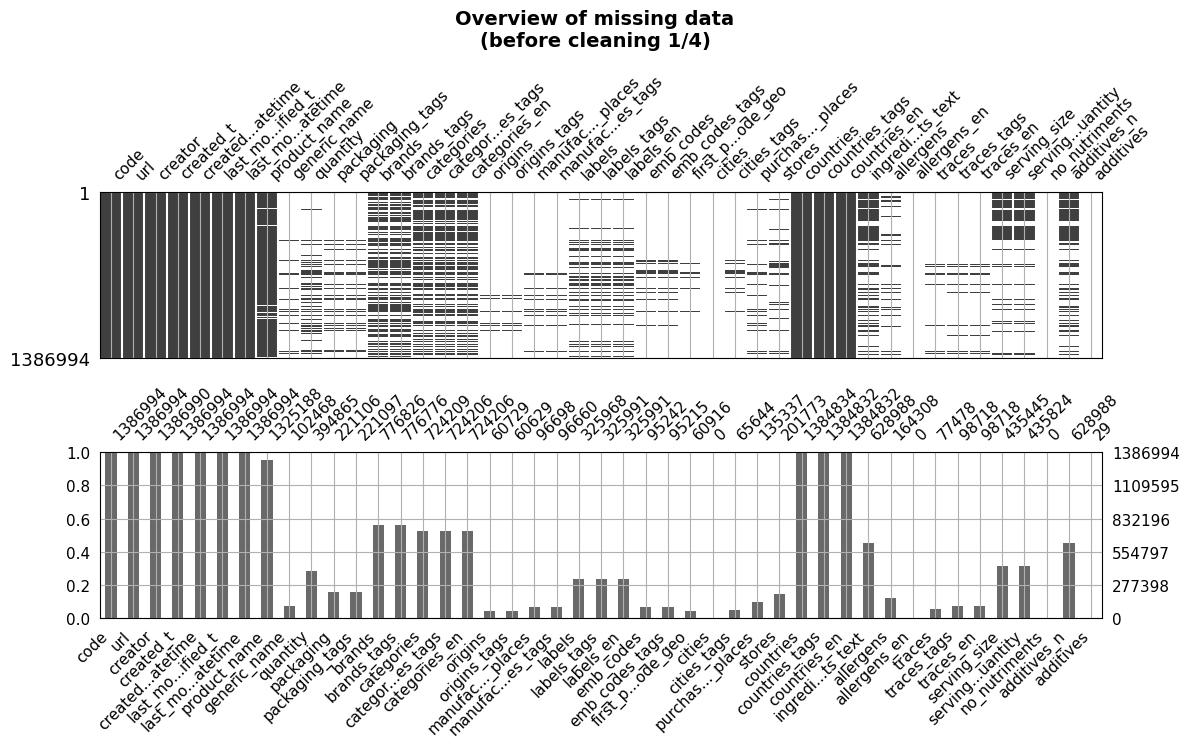

In [114]:
plot_export_missing(df, df.columns[0:45], 'C_0_3_missing_vals_1.png',
                    'Overview of missing data\n(before cleaning 1/4)',
                    shorten_label=True)

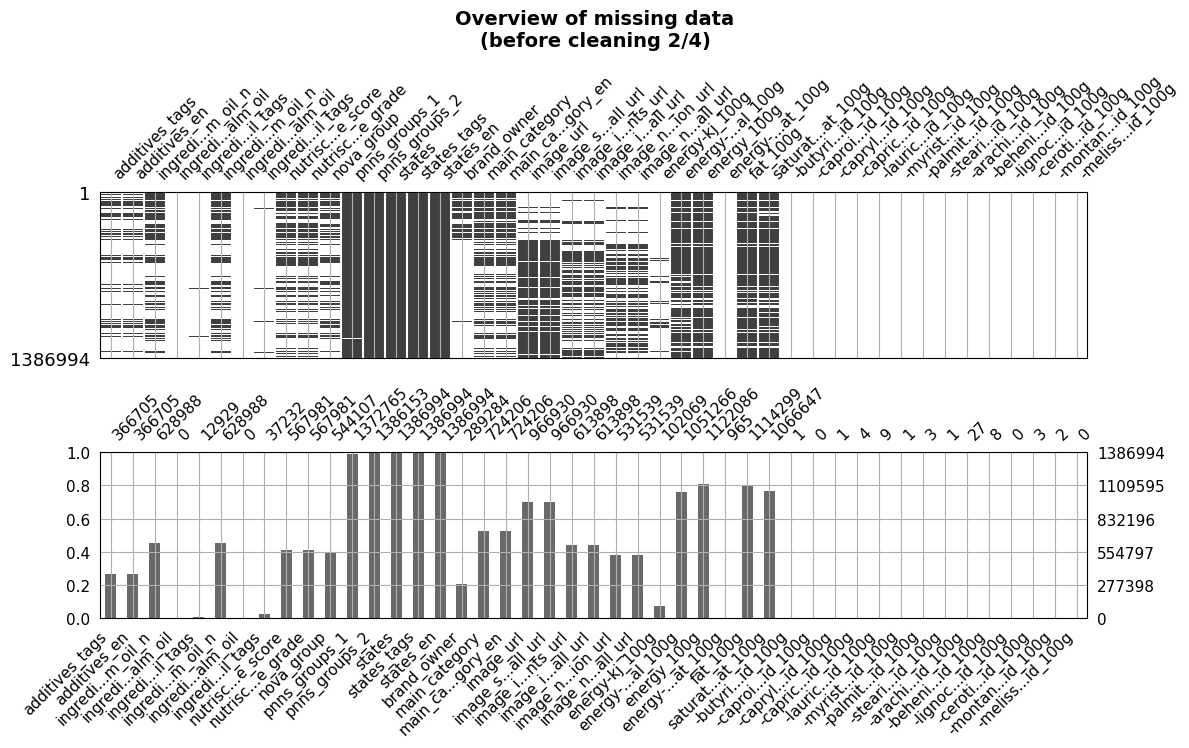

In [115]:
plot_export_missing(df, df.columns[45:90], 'C_0_3_missing_vals_2.png',
                    'Overview of missing data\n(before cleaning 2/4)',
                    shorten_label=True)

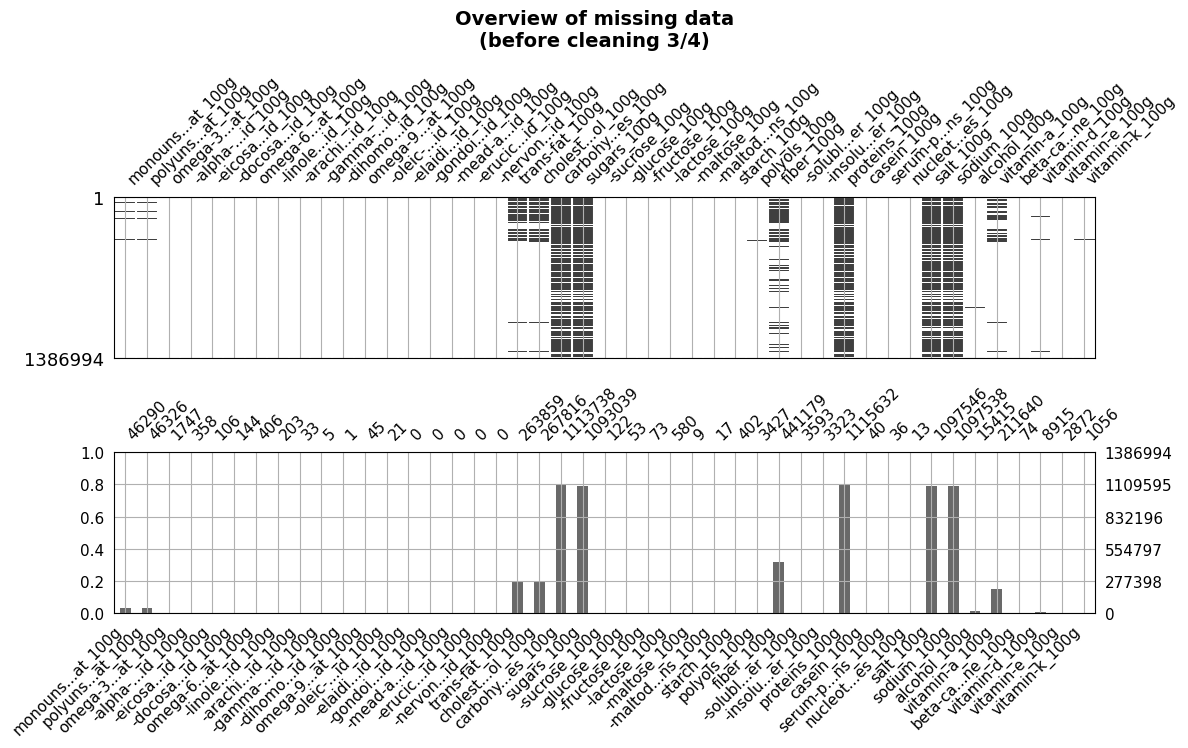

In [116]:
plot_export_missing(df, df.columns[90:135], 'C_0_3_missing_vals_3.png',
                    'Overview of missing data\n(before cleaning 3/4)',
                    shorten_label=True)

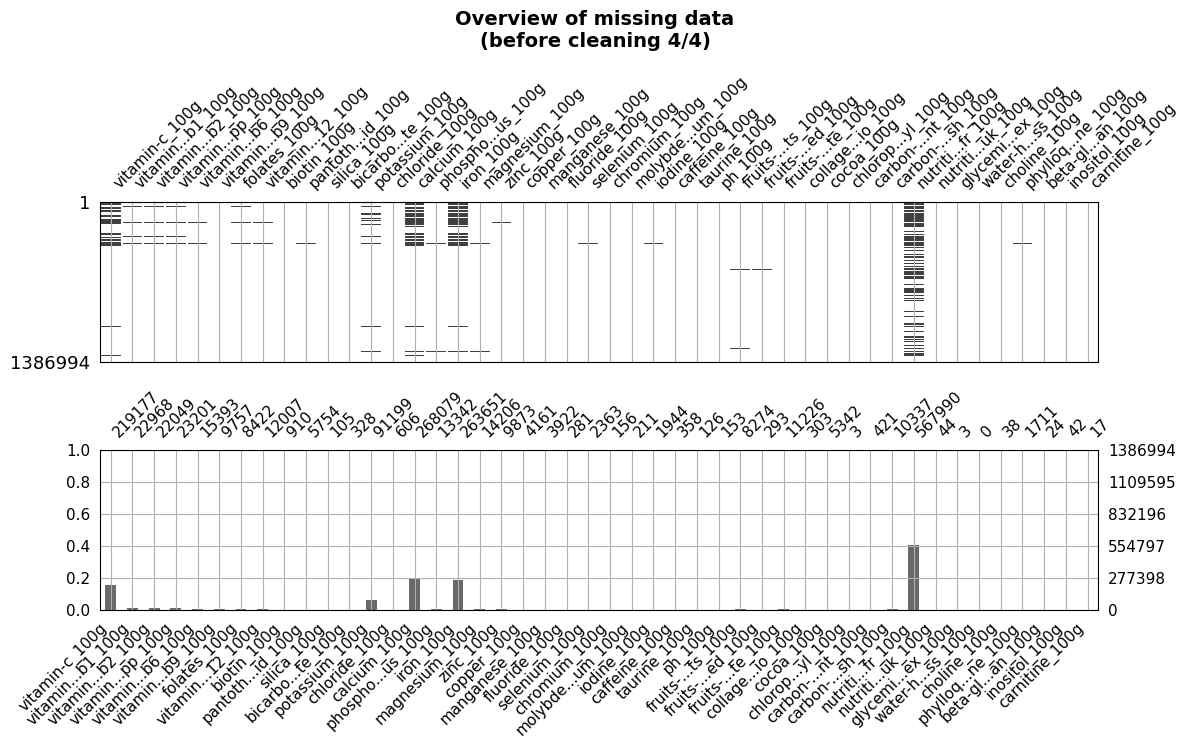

In [117]:
plot_export_missing(df, df.columns[135:181],'C_0_3_missing_vals_4.png',
                    'Overview of missing data\n(before cleaning 4/4)',
                    shorten_label=True)

In [118]:
speak('Description overview done')

Main conclusions :
- categorical and quantitative columns
- 181 columns, 1385447 rows
- large number of missing data (78% of null)


## 1 Feature selection

In [0]:
# Changing - to _ in column names

new_cols = [c.replace('-','_') for c in df.columns]
df = df.rename(columns=dict(zip(df.columns,new_cols)))

### 1.1 Filtering out non relevant columns
Some columns can immediately be classified as non useful for our project and therefore dropped : 
- columns relative to the image of the product ('image')
- columns relative to the level of completion of the row ('state') 


In [120]:
# Filtering out non relevant columns

li_col_del = list(df.columns[df.columns.str.contains('image')]) +\
             list(df.columns[df.columns.str.contains('states')]) +\
             ['brand_owner', 'last_modified_t', 'last_modified_datetime']

df.drop(columns=li_col_del, inplace=True)

print(df.shape)
print_null_pct(df)

(1386994, 169)
nb of null:  191961486 
pct of null:  81.9


### 1.2 Almost empty columns

Let's see how the columns are filled.


In [121]:
# Checking nb of not null values in the columns

nb_not_null = pd.DataFrame((~df.isna()).sum(axis =0), columns=['nb'])
nb_not_null.sort_values(by=['nb'], axis=0, ascending=True, inplace=True)
nb_not_null.T.head(150)

,_mead_acid_100g,_erucic_acid_100g,_caproic_acid_100g,_gondoic_acid_100g,_elaidic_acid_100g,allergens_en,no_nutriments,_nervonic_acid_100g,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil,_lignoceric_acid_100g,water_hardness_100g,_melissic_acid_100g,cities,_dihomo_gamma_linolenic_acid_100g,_stearic_acid_100g,_myristic_acid_100g,_caprylic_acid_100g,_butyric_acid_100g,_montanic_acid_100g,_palmitic_acid_100g,glycemic_index_100g,chlorophyl_100g,_cerotic_acid_100g,_capric_acid_100g,_gamma_linolenic_acid_100g,_behenic_acid_100g,_maltose_100g,_lauric_acid_100g,nucleotides_100g,carnitine_100g,_maltodextrins_100g,_oleic_acid_100g,beta_glucan_100g,_arachidic_acid_100g,additives,_arachidonic_acid_100g,serum_proteins_100g,choline_100g,casein_100g,...,additives_tags,quantity,serving_size,serving_quantity,fiber_100g,nova_group,nutriscore_grade,nutriscore_score,nutrition_score_fr_100g,ingredients_text,ingredients_that_may_be_from_palm_oil_n,additives_n,ingredients_from_palm_oil_n,main_category,main_category_en,categories_en,categories_tags,categories,brands_tags,brands,energy_kcal_100g,saturated_fat_100g,sugars_100g,sodium_100g,salt_100g,carbohydrates_100g,fat_100g,proteins_100g,energy_100g,product_name,pnns_groups_1,countries_tags,countries_en,countries,pnns_groups_2,creator,created_datetime,created_t,url,code
nb,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,3,3,3,3,4,5,8,9,9,13,17,17,21,24,27,29,33,36,38,40,...,366705,394865,435445,435824,441179,544107,567981,567981,567990,628988,628988,628988,628988,724206,724206,724206,724206,724209,776776,776826,1051266,1066647,1093039,1097538,1097546,1113738,1114299,1115632,1122086,1325188,1372765,1384832,1384832,1384834,1386153,1386990,1386994,1386994,1386994,1386994


In [122]:
# Displaying a table with bins
mask = pd.cut(nb_not_null['nb'], [-1,0,5,10,100,300,1000000]) # 
mask.value_counts(normalize=False, sort=False)

(-1, 0]           14
(0, 5]            12
(5, 10]            3
(10, 100]         17
(100, 300]        11
(300, 1000000]    92
Name: nb, dtype: int64

In [123]:
# Plotting nb of not null per column
@interact_manual
def plot_more_than_n_notna(n =(1,1000,50)):
   ax = nb_not_null['nb'][nb_not_null['nb']>n].reset_index()\
                .plot.bar(x='index', y='nb', figsize=(25,4))
   ax.set(yscale='log')
   return ax

interactive(children=(IntSlider(value=451, description='n', max=1000, min=1, step=50), Button(description='Run…

We choose a lower threshold for the number of notna values in a column at 300.

We also add some columns to the 'to_be_deleted', as they would require more data to be exploitable:

In [0]:
# Defining the "to-be-deleted" columns list

mask = pd.cut(nb_not_null['nb'], [-1,300])

li_col_del1 = list(mask[~mask.values.isna()].index)

li_col_del2 = ['carbon_footprint_100g',
               'carbon_footprint_from_meat_or_fish_100g',
#               'fruits_vegetables_nuts_100g',
#               'fruits_vegetables_nuts_estimate_100g',
               'ingredients_from_palm_oil_tags', 'origins',
               'ingredients_that_may_be_from_palm_oil_tags',
               'manufacturing_places', 'stores','cities_tags',
               'generic_name',
               'collagen-meat-protein-ratio_100g',
               'first_packaging_code_geo','purchase_places', 'emb_codes']

# Dropping columns with too much missing values
li_col_del3 = ['monounsaturated_fat_100g','polyunsaturated_fat_100g', 'omega_3_fat_100g',
           '_alpha_linolenic_acid_100g', 'omega_6_fat_100g', 
           'trans_fat_100g', 'cholesterol_100g',
           'caffeine_100g', 'cocoa_100g','_lactose_100g', 'starch_100g',
           '_soluble_fiber_100g', '_insoluble_fiber_100g',
           'vitamin_a_100g', 'vitamin_d_100g', 'vitamin_e_100g',
           'vitamin_k_100g', 'vitamin_c_100g', 'vitamin_b1_100g',
           'vitamin_b2_100g', 'vitamin_pp_100g', 'vitamin_b6_100g',
           'vitamin_b9_100g', 'folates_100g', 'vitamin_b12_100g',
           'biotin_100g', 'pantothenic_acid_100g', 'bicarbonate_100g',
           'potassium_100g', 'chloride_100g', 'calcium_100g',
           'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g',
           'copper_100g', 'manganese_100g', 'selenium_100g', 'iodine_100g',
           'phylloquinone_100g' ]

li_col_del = list(set(li_col_del1) | set(li_col_del2) | set(li_col_del3))

In [125]:
# Displaying names of columns with less than 300 entries

print('columns to delete',len(li_col_del))
for i, c in enumerate(li_col_del):
    print('\n'+c if i % 6 == 0 else c, end=' | ')

columns to delete 110

vitamin_d_100g | vitamin_a_100g | ph_100g | _myristic_acid_100g | biotin_100g | _elaidic_acid_100g | 
cities | stores | ingredients_from_palm_oil | omega_6_fat_100g | generic_name | iodine_100g | 
potassium_100g | vitamin_e_100g | _erucic_acid_100g | _montanic_acid_100g | beta_carotene_100g | _fructose_100g | 
vitamin_b2_100g | choline_100g | chromium_100g | _eicosapentaenoic_acid_100g | _behenic_acid_100g | beta_glucan_100g | 
polyunsaturated_fat_100g | vitamin_k_100g | _maltodextrins_100g | molybdenum_100g | iron_100g | cities_tags | 
copper_100g | _caproic_acid_100g | carbon_footprint_100g | _stearic_acid_100g | _gamma_linolenic_acid_100g | collagen-meat-protein-ratio_100g | 
no_nutriments | silica_100g | allergens_en | nucleotides_100g | additives | vitamin_b6_100g | 
chloride_100g | _sucrose_100g | ingredients_that_may_be_from_palm_oil | _mead_acid_100g | bicarbonate_100g | _linoleic_acid_100g | 
fruits_vegetables_nuts_dried_100g | _maltose_100g | _capric_ac

In [126]:
# Printing remaining columns

li_rem_col = [s for s in list(df.columns) if s not in li_col_del]
print('remaining columns',len(li_rem_col))
for i, c in enumerate(li_rem_col):
    print('\n'+c if i % 6 == 0 else c, end=' | ')

remaining columns 60

code | url | creator | created_t | created_datetime | product_name | 
quantity | packaging | packaging_tags | brands | brands_tags | categories | 
categories_tags | categories_en | origins_tags | manufacturing_places_tags | labels | labels_tags | 
labels_en | emb_codes_tags | countries | countries_tags | countries_en | ingredients_text | 
allergens | traces | traces_tags | traces_en | serving_size | serving_quantity | 
additives_n | additives_tags | additives_en | ingredients_from_palm_oil_n | ingredients_that_may_be_from_palm_oil_n | nutriscore_score | 
nutriscore_grade | nova_group | pnns_groups_1 | pnns_groups_2 | main_category | main_category_en | 
energy_kj_100g | energy_kcal_100g | energy_100g | energy_from_fat_100g | fat_100g | saturated_fat_100g | 
carbohydrates_100g | sugars_100g | polyols_100g | fiber_100g | proteins_100g | salt_100g | 
sodium_100g | alcohol_100g | fruits_vegetables_nuts_100g | fruits_vegetables_nuts_estimate_100g | collagen_meat_protein

In [127]:
# Dropping the columns

df = df.drop(columns=[c for c in li_col_del if c in df.columns])

print(df.shape)
print_null_pct(df)

(1386994, 60)
nb of null:  43541352 
pct of null:  52.3


We rearrange the columns with similar contents at the same place:

In [0]:
# Changing the name of some of the columns

df.rename(columns={'nutriscore_score': 'nutriscore',
                   'nutriscore_grade': 'nutrigrade',
                   'pnns_groups_1': 'pnns1',
                   'pnns_groups_2': 'pnns2',
                   'nutrition_score_fr_100g':'nutriscore_fr'},
          inplace=True)

In [0]:
# Function that moves similar names in an Index at the same place

def move_cat_containing(my_index, strings, order):
  idx_sel = []
  if order == 'last':
    index = my_index
  elif order == 'first':
    index = my_index[::-1]
  else:
    print("--- WARNING : index unchanged.\n -- Wrong order passed. Pass 'first' or 'last'")
    return my_index
  for s in strings:
    idx_sel += [i for i,x in enumerate(index) if x in index[index.str.contains(s)]]
  to_move = index[idx_sel]
  rank = max(idx_sel)
  mod_index = index.drop(to_move)
  for c in to_move:
    mod_index = mod_index.insert(rank,c)
  return mod_index if order=='last' else mod_index[::-1]

In [0]:
# Moving 'nutriscores', 'categories', info related to brand and to quantities

cols = df.columns
cols = move_cat_containing(cols,['name'], 'first')
cols = move_cat_containing(cols,['brand'], 'first')
cols = move_cat_containing(cols,['categ','pnns', 'label'], 'first')
cols = move_cat_containing(cols,['nutri', 'nova'], 'first')
cols = move_cat_containing(cols,['_100g'], 'last')
df = df.reindex(columns=cols)

In [131]:
# Checking columns in df

for i, c in enumerate(df.columns):
    print('\n'+c if i % 6 == 0 else c, end=' | ')


code | url | main_category_en | main_category | categories_en | categories_tags | 
categories | pnns2 | pnns1 | labels_en | labels_tags | labels | 
creator | created_t | created_datetime | product_name | quantity | packaging | 
brands_tags | brands | packaging_tags | origins_tags | manufacturing_places_tags | emb_codes_tags | 
countries | countries_tags | countries_en | ingredients_text | allergens | traces | 
traces_tags | traces_en | serving_size | serving_quantity | additives_n | additives_tags | 
nutriscore_fr | nutrigrade | nutriscore | nova_group | additives_en | ingredients_from_palm_oil_n | 
ingredients_that_may_be_from_palm_oil_n | energy_kj_100g | energy_kcal_100g | energy_100g | energy_from_fat_100g | fat_100g | 
saturated_fat_100g | carbohydrates_100g | sugars_100g | polyols_100g | fiber_100g | proteins_100g | 
salt_100g | sodium_100g | alcohol_100g | fruits_vegetables_nuts_100g | fruits_vegetables_nuts_estimate_100g | collagen_meat_protein_ratio_100g | 

### 1.3 Columns with redundant information

Some of the columns seem to contain similar information. For example : 
  - 'created_t' vs.	'created_datetime'
  - 'brands' vs.	'brands_tags'
  - 'categories	' vs.	'categories_tags'  vs.	'categories_en'  
  - 'origins' vs.	'origins_tags'
  - 'manufacturing_places' vs.	'manufacturing_places_tags'
  - 'labels' vs.	'labels_tags'  vs.	'labels_en' 
  - 'emb_codes' vs.	'emb_codes_tags'
  - 'countries' vs.	'countries_tags'  vs.	'countries_en'
  - 'traces' vs.	'traces_tags'  vs.	'traces_en'
  - 'additives_n' vs. 'additives' vs.	'additives_tags'  vs.	'additives_en'


Let's see if some of them can be dropped or their content gathered in only one column.
To that end, we define a function '**comp_df**' that :
- compares the content of two columns col1 and col2 of the dataframe
- prints the number or rows with 1) both columns, 2) col1 only, 3) col2 only, and 4) none of them filled
- returns indexes of 1) data in both columns, 2) data only in col1, 3) data only in col2, and 4) no data at all.

After that, we check and compare the content of the columns when both are filled in order to get familiar with the content of the database and determine the columns that can be dropped.

In [0]:
# Comparing filled values in two columns
''' returns indices where both are filled, or first only, or second, or none'''

def comp_df (df, col1, col2, print_option):
  m_both = (~df[[col1,col2]].isna()).sum(axis=1)==2 # mask for both cells filled
  m_one = (~df[[col1,col2]].isna()).sum(axis=1)==1 # mask for only one cell filled
  m_col1 = m_one & ~df[col1].isna() # mask for only col1 cell filled
  m_col2 = m_one & ~df[col2].isna() # mask for only col2 cell filled
  mnone = ~m_one & ~m_both
  ind_both = df.index[m_both].to_list()
  ind_col1 = df.index[m_col1].to_list()
  ind_col2 = df.index[m_col2].to_list()
  ind_none = df.index[mnone].to_list()
  if print_option :
    print("nb rows both filled: ", len(ind_both))
    print("nb rows with only", col1, "filled: ", len(ind_col1))
    print("nb rows with only", col2, "filled: ", len(ind_col2))
    print("nb rows not filled: ", len(ind_none))
  else:
    pass
  return(ind_both, ind_col1, ind_col2, ind_none)

In [133]:
# Printing result of comparison in each case:

li_col = ['packaging', 'brands', 'categories', 
        'labels', 'countries', 'traces']
for c in li_col:
  c1 = c
  c2 = c+'_tags'
  print('COLUMN', c,':')
  t_ind = comp_df(df, c1, c2, True)
  df.loc[t_ind[1], [c1,c2]] = np.nan

COLUMN packaging :
nb rows both filled:  221095
nb rows with only packaging filled:  11
nb rows with only packaging_tags filled:  2
nb rows not filled:  1165886
COLUMN brands :
nb rows both filled:  776768
nb rows with only brands filled:  58
nb rows with only brands_tags filled:  8
nb rows not filled:  610160
COLUMN categories :
nb rows both filled:  724206
nb rows with only categories filled:  3
nb rows with only categories_tags filled:  0
nb rows not filled:  662785
COLUMN labels :
nb rows both filled:  325949
nb rows with only labels filled:  19
nb rows with only labels_tags filled:  42
nb rows not filled:  1060984
COLUMN countries :
nb rows both filled:  1384832
nb rows with only countries filled:  2
nb rows with only countries_tags filled:  0
nb rows not filled:  2160
COLUMN traces :
nb rows both filled:  77478
nb rows with only traces filled:  0
nb rows with only traces_tags filled:  21240
nb rows not filled:  1288276


We design an interactive feature that helps browsing the data and compare the content of XXX AND XXX_tags columns :

In [134]:
@interact_manual
def print_comp_info(col=li_col):
  c1 = col
  c2 = c1+'_tags'
  # Comparing content of 2 columns, print info and returns indexes 
  t_ind = comp_df(df, c1, c2, True)
  # Displaying a random sample of cells:
  '''- when col1 only is filled
  - when col2 only is filled
  - when both columns are filled'''
  display_side_by_side(df.loc[t_ind[1],[c1, c2]]\
                       .sample(5 if len(t_ind[1])>5 else len(t_ind[1])),
                      df.loc[t_ind[2], [c1, c2]]\
                       .sample(5 if len(t_ind[2])>5 else len(t_ind[2])),
                      df.loc[t_ind[0], [c1, c2]]\
                       .sample(5 if len(t_ind[0])>5 else len(t_ind[0])))

interactive(children=(Dropdown(description='col', options=('packaging', 'brands', 'categories', 'labels', 'cou…

After examination of all the columns above-listed, we decide :
- to set values of the 'XXX' column to NaN if not matching with a non NaN value in the 'XXX_tags' column (as we found that they correspond to erroneous values ('?', '/', '-', etc.));
- to drop 'created_t' and 'last_modified_t';
- to drop 'packaging_tags', 'brands_tags', 'categories_tags', 'origins_tags', 'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags', 'countries_tags', 'additives_tags', as the data they contain are redundant with 'XXX' or 'XXX_en' columns;
- to drop 'labels_en' as it seems to be too heavily filtered with a lot of 'unknown values.
- to drop 'traces' and 'traces_en' (instead of 'traces_tags'), as it is less filled then 'traces_tags' and traces_tags contains langage indicator.
- to drop 'additives' column, as it does not contain enough data (29 entries), that are however in english in 'additives_en'
- to keep '_en' columns and drop french column as they will be easier to manage

In [0]:
# Setting values of the 'XXX' column to NaN if no value in 'XXX_tag'

t_ind = comp_df(df, c1, c2, False)
df.loc[t_ind[1], [c1,c2]] = np.nan

In [136]:
# Dropping unuseful columns

li_col_del = ['created_t','packaging_tags', 'countries',
             'brands_tags', 'categories_tags', 'origins_tags', 
             'manufacturing_places_tags', 'labels_tags', 'labels_en',
             'emb_codes_tags','countries_tags', 'traces', 'traces_en',
             'additives_tags', 'categories', 'main_category']
print("shape before", df.shape)
df.drop(columns=li_col_del, inplace=True)
print("shape after", df.shape)

shape before (1386994, 60)
shape after (1386994, 44)


In [0]:
# Changing the name of some of the columns

df.rename(columns={'countries_en': 'countries',
                   'traces_tags': 'traces',
                   'additives_en': 'additives',
                   'main_category_en': 'main_category',
                   'categories_en': 'categories',
                   'nutrition_score_fr_100g':'nutriscore_fr'},
          inplace=True)

In [138]:
# Checking the remaining columns

for i, c in enumerate(df.columns):
    print('\n'+c if i % 6 == 0 else c, end=' | ')


code | url | main_category | categories | pnns2 | pnns1 | 
labels | creator | created_datetime | product_name | quantity | packaging | 
brands | countries | ingredients_text | allergens | traces | serving_size | 
serving_quantity | additives_n | nutriscore_fr | nutrigrade | nutriscore | nova_group | 
additives | ingredients_from_palm_oil_n | ingredients_that_may_be_from_palm_oil_n | energy_kj_100g | energy_kcal_100g | energy_100g | 
energy_from_fat_100g | fat_100g | saturated_fat_100g | carbohydrates_100g | sugars_100g | polyols_100g | 
fiber_100g | proteins_100g | salt_100g | sodium_100g | alcohol_100g | fruits_vegetables_nuts_100g | 
fruits_vegetables_nuts_estimate_100g | collagen_meat_protein_ratio_100g | 

In [139]:
print(df.shape)
print_null_pct(df)

(1386994, 44)
nb of null:  30124077 
pct of null:  49.4


In [140]:
speak('Filtered out unmeaningful columns')

## 2 Dealing with missing or erroneous data

### 2.0 Categorical columns with list of categories

In [0]:
cols = ['brands', 'packaging', 'countries', 'labels', 'traces', 'additives',
        'allergens', 'main_category', 'categories','pnns2', 'pnns1']

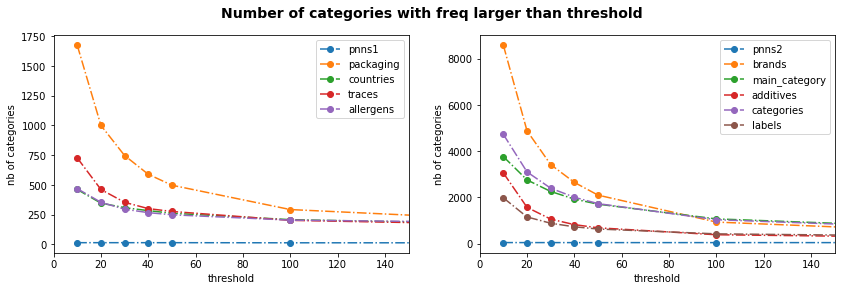

In [142]:
# Checking lower number of occurences in cat columns

fig, axs = plt.subplots(1,2)
thresh = [10,20,30,40,50,100,250,500,1000,5000]

for i, c in enumerate(['pnns1', 'packaging', 'countries',\
                      'traces',  'allergens']):
    ser = df[c].value_counts()
    axs[0].plot(thresh, np.array([len(ser[ser>t]) for t in thresh])+(i*30),
             label=c, marker='o', ls='-.')
    
for i, c in enumerate([ 'pnns2', 'brands','main_category','additives',\
                      'categories', 'labels']):
    ser = df[c].value_counts()
    axs[1].plot(thresh, np.array([len(ser[ser>t]) for t in thresh])+(i*30),
             label=c, marker='o', ls='-.')

[(ax.set_xlabel('threshold'),ax.set_ylabel('nb of categories')) for ax in axs];
[ax.set(xlim=(0,150)) for ax in axs];
[ax.legend() for ax in axs];
#[ax.set_xscale('log') for ax in axs];
fig.suptitle('Number of categories with freq larger than threshold',
             fontweight='bold', fontsize=14)
plt.gcf().set_size_inches(14,4)
plt.savefig('/content/C_2_0_cat_nb_vs_freq_thr.png', dpi=400);
plt.show()

In order to keep a maximum of data, we put the threshold to 15 minimum occurence for a category.

In [0]:
n=15

#### Preparing for cleaning

In [0]:
# Cleaning strings in columns

for c in cols:
    df[c] = df[c].astype('object')
    df[c] = df[c].fillna('unknown')
    df[c] = df[c].astype('object')
    df[c] = df[c].str.lower().apply(str)
    df[c] = df[c].str.replace('ô', 'o').str.replace('é', 'e')

Special: pnns

In [0]:
# Renaming some of the categories to avoid duplicates

df['pnns2'] = df['pnns2'].replace('pizza pies and quiche', 'pizza pies and quiches')
df['pnns1'] = df['pnns1'].replace([r'[-]'], [' '], regex=True)

#### Detecting columns with lists

In [146]:
# Printing columns containing lists or not

for c in cols:
    n_lists = df[c].str.contains(',').sum()
    if df[c].str.contains(',').sum():
        print(c.upper()+': ' + str(n_lists) + ' lists !!')
    else:
        print(c + ': - no list - ')

BRANDS: 83128 lists !!
PACKAGING: 112151 lists !!
COUNTRIES: 80392 lists !!
LABELS: 149358 lists !!
TRACES: 65446 lists !!
ADDITIVES: 281949 lists !!
ALLERGENS: 73578 lists !!
main_category: - no list - 
CATEGORIES: 623365 lists !!
pnns2: - no list - 
pnns1: - no list - 


In [0]:
# Splitting categories in 2 groups: containing lists, or not

multi_cat_cols = ['categories', 'countries', 'brands', 'packaging', 'additives',
                  'labels', 'traces', 'allergens']
cat_cols = ['main_category', 'pnns1', 'pnns2']

#### Splitting, extracting main, dropping less frequent values

categories with lists

In [0]:
# Setting to nan categories with less than freq 15 | returning tuples for others  

def filter_main_categories(ser,n):
    ser_m = ser
    flat_values = pd.Series([item for sublist in ser.str.split(',')\
                            for item in sublist])
    cat_occ = flat_values.value_counts()
    to_keep = cat_occ[cat_occ>n].index
    ser_m = ser_m.apply(lambda x: tuple([s.strip() for s in x.split(',')\
                                            if s.strip() in to_keep]))
    return ser_m

In [0]:
# Applying filter on all list columns

for c in multi_cat_cols:
    # -- Creating a new column with filtered list of countries
    df[c+'_tuple'] = filter_main_categories(df[c],n)
    # -- Creating a column with only one main (first) country
    df[c+'_main'] = df[c+'_tuple']\
                            .apply(lambda x: x[0] if x else 'unknown')
    # -- Reordering the columns
    df = df.reindex(columns=move_cat_containing(df.columns,[c], 'first'))
    # -- Deleting old column
    del df[c]

categories without lists

In [0]:
# Adding new 'XXX_main' columns to the list to be filtered once more

cat_cols = cat_cols+[s+'_main' for s in multi_cat_cols]

In [151]:
# Printing number of unique values of category columns

print('before: ',[(cat+' ('+str(df[cat].nunique())+') ') for cat in cat_cols])

for c in cat_cols:
    cat_occ = df[c].value_counts()
    to_keep = cat_occ[cat_occ>n].index
    df[c] = df[c].where(df[c].isin(to_keep), 'unknown')

print('after: ',[(cat+' ('+str(df[cat].nunique())+') ') for cat in cat_cols])

before:  ['main_category (25736) ', 'pnns1 (10) ', 'pnns2 (40) ', 'categories_main (393) ', 'countries_main (153) ', 'brands_main (5868) ', 'packaging_main (860) ', 'additives_main (287) ', 'labels_main (820) ', 'traces_main (68) ', 'allergens_main (74) ']
after:  ['main_category (3097) ', 'pnns1 (10) ', 'pnns2 (40) ', 'categories_main (195) ', 'countries_main (143) ', 'brands_main (5703) ', 'packaging_main (631) ', 'additives_main (216) ', 'labels_main (553) ', 'traces_main (37) ', 'allergens_main (27) ']


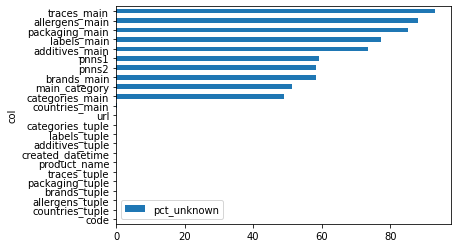

In [152]:
# Percentage of 'unknown' in categorical data

tot = df.shape[0]
ser = pd.DataFrame([[c, df[c].str.contains('unknown').sum()*100/tot] \
                 for c in df.select_dtypes('object').columns],
                 columns=['col', 'pct_unknown']).set_index('col')
ser.sort_values('pct_unknown').plot.barh()
plt.savefig('/content/C_2_0_unknown_cat_values.png', dpi=400);
plt.show()

In [0]:
# Setting unknown to nan

for c in ser.index:
    df[c] = df[c].replace('unknown', np.nan)

### 2.1 'product_name' column

In [0]:
# Replacing invalid names (1 or 0 characters) with np.NaN
df.loc[df[df['product_name'].str.len()<2].index,'product_name'] = np.nan

### 2.2 'code' column

Let's first check the 'code' column for completion and validity of the data:

In [155]:
# Checking nb of null values in 'code' column
df['code'].isna().sum()

0

No null value in the 'code' column.

We will now create a new column 'code_val' indicating if the barcode is valid.

In [156]:
# Verification of barcodes (EAN-13, EAN-8 and UPC (12-digit) format)
# Creation of a new column : 'code_val' (bool) barcode valid or not
df.insert(1,'code_val', df['code'].apply(is_valid))
print("nb of valid codes: ", df['code_val'].sum())
print("nb of invalid codes: ", (~df['code_val']).sum())
print("pctage of valid codes: {:.2f}%".format(df['code_val'].sum()*100/df.shape[0]))

nb of valid codes:  1356119
nb of invalid codes:  30875
pctage of valid codes: 97.77%


### 2.3 'quantity' column

In [0]:
# Changing the type of quantity column from 'category' to 'quantity'
df['quantity'] = df['quantity'].astype('object')

In [0]:
# Function selecting the most relevant tuple (num,unit) in the list
# by order of priority : unit in li_prio1, then in li_prio2

def sel_gr(li, li_prio1, li_prio2):
  res = 0
  nums, units = li
  tab_t_u = []
  ind = np.nan
  for i in units:
    if  i in li_prio1:
      tab_t_u.append(2)
    elif  i in li_prio2:
      tab_t_u.append(1)
    else:
      tab_t_u.append(0) if i!='' else tab_t_u.append(np.nan)
  i_tab1 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==2] # indexes of all volumes (prio1)
  i_tab2 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==1] # indexes of all masses (prio2)
  i_tab0 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==0] # indexes of all others (prio3)
  if len(i_tab1)>0: # prio1 (vol)
    ind = i_tab1[np.argmax([nums[i] for i in i_tab1])]
  elif len(i_tab2)>0: # prio2 (mass)
    ind = i_tab2[np.argmax([nums[i] for i in i_tab2])]
  else:
    ind = i_tab0[np.argmax([nums[i] for i in i_tab0])] if len(i_tab0)>0 else np.nan
  return(nums[ind], units[ind]) if ind is not np.nan else (np.nan, np.nan)

In [159]:
# Creating a new database with 'quantity' data (wo null, same index)
df_q = df['quantity'].dropna().to_frame()
print("Nb of notna values in 'quantity': {} on {}, i.e. {:.1f}%"\
           .format(df_q.shape[0], df.shape[0],df_q.shape[0]*100/df.shape[0]))
display(df_q.head(15).T)

Nb of notna values in 'quantity': 394865 on 1386994, i.e. 28.5%


,1,3,4,18,40,50,64,96,99,120,153,157,158,160,162
quantity,130 g,100g,dgesc,80 g,1kg,4 g,1,500 g,120g,Vrac,250 ml,2.46 kg,230g,100 g,60 capsules


Then we design routines that will be used to extract from the 'quantity' column :
- all numerical values
- all possible corresponding units

In [0]:
'''Cleaning 'quantity' column routines''' 

# To ensure safe execution of function 'float'
def safe_exe(def_val, function, *args):
    try: return function(*args)
    except: return def_val

# Conversion of string in float if possible, else 0 (accepts 'n1 x n2' string)
def conv_float(my_str):
  idx = 0
  if 'x' in my_str:
    idx = my_str.find('x')
    n1 = safe_exe(0, float, my_str[:idx])
    n2 = safe_exe(0, float, my_str[idx+1:])
    return n1*n2
  else:
    return safe_exe(0, float, my_str)

# Splits string in a list of tuples (number, associated unit)
def num_units(my_str):
  my_str = my_str.lower().strip()
  regex = r'([0-9.,x ]*)\s*([^()0-9 !,\-±=\*\+/.-\?\[\]]*\s*)'
  res = re.findall(regex, my_str)
  res.remove(('', ''))
  num = [conv_float(gr[0].replace(' ','').replace(',','.')) for gr in res]
  unit = [gr[1].strip()  for gr in res]
  res=list(zip(num,unit))
  return num, unit

We manually make a selection among the unique values of units of denominations of mass units and volume units.

In [0]:
# Classifying main relevant units in 'mass' and 'volume' units
li_u_mass = ['g', 'kg', 'gr', 'grammes', 'grs','st', 'mg', 'gramm', 'lb','gram',
             'grams', 'gramos', 'lbs', 'gm', 'lt', 'lts','gramme', 'kilo','公克',
             'grammi', 'kgs', 'kgr', 'gms', 'g-', 'grms','pound', 'pounds',
             'ounces','ounce','grm', 'grames','غرام', 'جرام','غ', 'غم','جم',
             'g℮', 'г', 'кг', '克', 'грамм', 'גרם','kilogramm','gramas', 'γρ',
             'kilogrammae','livres','grame', 'kilos'] 
li_u_vol = ['ml','dl','l','cl', 'oz', 'litre', 'fl', 'litres', 'liter','litro',
            'litri','litr',  'ltr', 'lt', 'lts', 'gallon','half-gallon',
            'litros','litroe', 'liters', 'cc', 'kl', 'pint','pints', 'gal',
            'mls', 'centilitres', 'لتر','مل','ل','ليتر', 'มล', 'ลิตร', 'мл', 'л',
            'litrè', 'milliliter','millilitre', 'литр', 'литра', 'mml',
            'מ״ל','millilitres','λίτρο', 'mĺ', 'cm', 'cm³' ]

Let's apply these functions to the 'quantity' column:

In [162]:
# Splitting numerical and unit values in two new columns
df_q['analysis'] = df_q['quantity'].apply(num_units)
df_q[['num_gr','unit_gr']] = pd.DataFrame(df_q['analysis'].tolist(),
                                          index=df_q['analysis'].index)
# Selecting the main (num, unit) as the most relevant tuple from 'analysis'
# -> first mass, then volume
my_fun = lambda x: sel_gr(x, li_u_vol, li_u_mass)
df_q[['num','unit']] = pd.DataFrame(df_q['analysis'].apply(my_fun).tolist(),
                                    index=df_q['analysis'].index)
df_q.head(15).T

,1,3,4,18,40,50,64,96,99,120,153,157,158,160,162
quantity,130 g,100g,dgesc,80 g,1kg,4 g,1,500 g,120g,Vrac,250 ml,2.46 kg,230g,100 g,60 capsules
analysis,"([130.0], [g])","([100.0], [g])","([0], [dgesc])","([80.0], [g])","([1.0], [kg])","([4.0], [g])","([1.0], [])","([500.0], [g])","([120.0], [g])","([0], [vrac])","([250.0], [ml])","([2.46], [kg])","([230.0], [g])","([100.0], [g])","([60.0], [capsul..."
num_gr,[130.0],[100.0],[0],[80.0],[1.0],[4.0],[1.0],[500.0],[120.0],[0],[250.0],[2.46],[230.0],[100.0],[60.0]
unit_gr,[g],[g],[dgesc],[g],[kg],[g],[],[g],[g],[vrac],[ml],[kg],[g],[g],[capsules]
num,130.00,100.00,0.00,80.00,1.00,4.00,NaN,500.00,120.00,0.00,250.00,2.46,230.00,100.00,60.00
unit,g,g,dgesc,g,kg,g,NaN,g,g,vrac,ml,kg,g,g,capsules


We can then create a column giving the type of unit. 

In [0]:
# Creating a new column with type of the main unit
d_mass_vol = dict([(u,'mass') if u in li_u_mass else\
                  (u,'vol')  if u in li_u_vol else\
                  (u,'other') for u in df_q['unit'].unique()])
df_q['unit_type'] = df_q['unit'].dropna().map(d_mass_vol)

We drop all row where 'unit' is null or 'num' is not in ]0, 10000[.

In [0]:
# Dropping rows where unit or num is null 
df_q = df_q.dropna(subset=['unit', 'num'])
# Dropping rows where num is zero, negative or greater than 10000
df_q = df_q[df_q['num'].between(0.0001,10000)]

Let's now merge the new features in df.

In [165]:
# Merging df_q with df, reordering the columns, deleting original 'quantity'
print("df before: ", df.shape,
      " | df_q: ", df_q.shape)
df = df.merge(df_q[['num', 'unit','unit_type']],
                      how = 'left',  left_index=True, right_index=True)
df = df.rename(columns = {'num':'quantity_num',
                          'unit':'quantity_unit',
                          'unit_type':'quantity_type'})
df['quantity_type'].fillna('unknown')
df = df.reindex(columns=move_cat_containing(df.columns,['quant'], 'first'))
print("df after: \n", df.shape)

del df['quantity']

df before:  (1386994, 53)  | df_q:  (383641, 7)
df after: 
 (1386994, 56)


In [166]:
# Showing df shape and column order
for i,c in enumerate(df.columns):
  print('\n'+c, end=' | ') if (i) % 6 == 0  else print(c, end=' | ')


code | code_val | categories_main | categories_tuple | url | main_category | 
labels_main | labels_tuple | pnns2 | quantity_type | quantity_unit | quantity_num | 
serving_quantity | pnns1 | creator | created_datetime | product_name | countries_main | 
brands_main | packaging_main | packaging_tuple | brands_tuple | allergens_main | allergens_tuple | 
countries_tuple | ingredients_text | additives_main | traces_main | traces_tuple | additives_tuple | 
additives_n | serving_size | nutriscore_fr | nutrigrade | nutriscore | nova_group | 
ingredients_from_palm_oil_n | ingredients_that_may_be_from_palm_oil_n | energy_kj_100g | energy_kcal_100g | energy_100g | energy_from_fat_100g | 
fat_100g | saturated_fat_100g | carbohydrates_100g | sugars_100g | polyols_100g | fiber_100g | 
proteins_100g | salt_100g | sodium_100g | alcohol_100g | fruits_vegetables_nuts_100g | fruits_vegetables_nuts_estimate_100g | 
collagen_meat_protein_ratio_100g | 

The quantities must now be translated to either g or ml. We'll then drop all the other units.

In [0]:
# Creating dictionaries to translate
vol_1 = dict([(s, 1000) for s in ['litres', 'liter','litro', 'l', 'litre', 'λίτρο',
                         'litrè', 'litri','litr','ltr','lt', 'lts',
                         'litros','litroe', 'liters', 'لتر', 'ل','ليتر', 
                         'л', 'ลิตร','литр', 'литра']])
vol_2 = dict([(s, 1) for s in ['ml', 'mls', 'mls','مل', 'มล', 'мл',
                              'milliliter','millilitre','מ״ל','millilitres',
                              'mĺ', 'cm', 'cm³', 'cc']])
vol_3 = { 'oz': 29.57, 'cl': 10, 'centilitres': 10, 'dl': 10,
         'gallon':3.78541 , 'gal' : 3.78541, 'half-gallon': 1.89271}

dict_vol = dict(list(vol_1.items())+list(vol_2.items())+list(vol_3.items()))
dict_vol = dict([(k,(v,'ml')) for k,v in dict_vol.items()])

mass_1 = dict([(s, 1000) for s in ['kg', 'kilo', 'кг', 'kilogrammae',
                                   'kilogramm', 'kilos', 'kgs', 'kgr']])
mass_2 = dict([(s, 1) for s in ['g','gr','grammes','grs','gramm','gram','grams',
                                'gramos','gm','gramme','公克','γρ','grammi',
                                'gms','g-','grms','grm','grames','غرام', 'جرام',
                                'غ','غم','جم','g℮', 'г','克', 'грамм','גרם',
                                'gramas','grame']])
mass_3 = dict([(s, 453.592) for s in ['lb','lbs', 'livres', 'pound', 'pounds']])
mass_4 = {'st': 6350.29, 'mg': 0.001,'fl': 33.81,'pint': 473.18,
          'pints' : 473.18, 'ounces':28.3495, 'ounce': 28.3495}
dict_mass = dict(list(mass_1.items())+list(mass_2.items())\
                +list(mass_3.items())+list(mass_4.items()))
dict_mass = dict([(k,(v,'g')) for k,v in dict_mass.items()])

dict_m_v = dict(list(dict_vol.items())+list(dict_mass.items()))

In [0]:
# Creating new columns in a temporary dataframe
ser = df['quantity_unit'].map(dict_m_v).dropna(axis=0)
df_temp = pd.DataFrame(list(ser.values),
                         columns =['coef', 'quantity_unit_n'], index=ser.index)
df_temp['quantity_num_n'] = df['quantity_num'].mul(df_temp['coef'])

In [169]:
# Checking
pd.concat([df_temp,df[['quantity_num', 'quantity_unit']]], axis=1).sample(5)

,coef,quantity_unit_n,quantity_num_n,quantity_num,quantity_unit
792476,1000.00,g,1000.00,1.00,kg
1350496,nan,NaN,nan,nan,NaN
65059,nan,NaN,nan,nan,NaN
645626,nan,NaN,nan,nan,NaN
1213668,nan,NaN,nan,nan,NaN


In [170]:
# Merging to df, reordering the columns, deleting old 'quantity' columns
print("df before: ", df.shape)
df = df.merge(df_temp[['quantity_num_n', 'quantity_unit_n']],
                      how = 'left',  left_index=True, right_index=True)
del df['quantity_num'], df['quantity_unit']
df = df.rename(columns = {'quantity_num_n':'quantity_num',
                          'quantity_unit_n':'quantity_unit'})
df = df.reindex(columns=move_cat_containing(df.columns,['quant'], 'first'))
print("df after: ", df.shape)

df before:  (1386994, 55)
df after:  (1386994, 55)


Let's filter out outliers

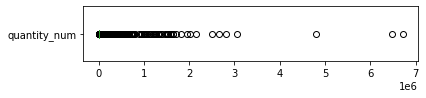

In [171]:
# Plotting boxplot of 'quantity_num'
df['quantity_num'].plot.box(vert=False);
plt.gcf().set_size_inches(6,1)

In [0]:
# Putting outliers to nan
df['quantity_num'] = df['quantity_num'].where(df['quantity_num'].between(0,10001))

In [173]:
speak('quantity column cleaned')

Let's have a look to serving quantities.

In [174]:
# Preview
my_c = df.columns[df.columns.str.contains('serving')]
df[my_c][df[my_c].notna().any(axis=1)].sample(5)

,serving_quantity,serving_size
199172,15.00,3 Tbsp (15 g)
1111378,32.00,32g
943143,100.00,100ml
174566,25.00,0.25 cup (25 g)
329382,32.00,2 Tbsp (32 g)


Column 'serving quantity' is already cleaned, and either in g or ml.

* We keep it and drop 'serving_size'
* We drop outliers
* We put to np.nan all 0 value

In [0]:
del df['serving_size']

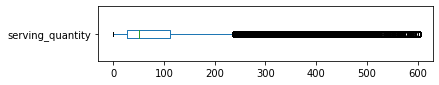

In [176]:
# Putting abnormal values to nan, checking distribution
df['serving_quantity'] = df['serving_quantity'].clip(0,600)
df['serving_quantity'].map({0:np.nan, 600:np.nan})
df['serving_quantity'].plot.box(vert=False);
plt.gcf().set_size_inches(6,1)

### 2.4 'XXX_100g' nutritional components columns

Let's have a look at the distribution of values for _100g columns.

In [177]:
X_100g_cols = df.columns[(df.columns.str.contains('_100g'))&\
                         ~(df.columns.str.contains('energy'))]

@interact_manual
def plot_box_xlim(xmax=(10,1000,50)):
    df[X_100g_cols].boxplot(vert=False, figsize=(18,10))
    plt.gca().set(xlim=(0,xmax));

interactive(children=(IntSlider(value=460, description='xmax', max=1000, min=10, step=50), Button(description=…

We need to get rid of values under 0 and above 100

In [0]:
# Changing outliers to np.nan
for c in X_100g_cols:
    df.loc[:,c] = df[c].where(df[c].between(0,100), other=np.nan)

Now the sum of all the X_100g columns must be lower than 100.

We take care to remove sub-columns that detail composition of other columns as for example *'fat_100g'* is composed of *'saturated-fat_100g', 'monounsaturated-fat_100g',	'polyunsaturated-fat_100g',	'omega-3-fat_100g',	'-alpha-linolenic-acid_100g',	'omega-6-fat_100g',	'trans-fat_100g'* and	*'cholesterol_100g'*.

In [0]:
# Listing sub-columns, and defining new list of main cols without sub-columns

# -- all the columns which sum should be 100 or less
sum_100g_cols = ['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g']

# -- main sub-columns
fat_cols = [c for c in ['saturated_fat_100g', 'monounsaturated_fat_100g',
            'polyunsaturated_fat_100g', 'omega_3_fat_100g','omega_6_fat_100g',
             'trans_fat_100g','cholesterol_100g'] if c in df.columns]
carb_cols = [c for c in ['sugars_100g',	'starch_100g',	'polyols_100g',
                         'fiber_100g'] if c in df.columns]
salt_cols = ['sodium_100g']

# -- sub-sub-columns
sug_cols = [c for c in ['_lactose_100g'] if c in df.columns]
fib_cols = [c for c in ['_soluble-fiber_100g','-insoluble-fiber_100g']\
                                            if c in df.columns]

We check each group of sub-columns and then fill with np.nan sub-columns where sum of components is lower than the value in the main column.

In [180]:
# Checking for rows where sum of components exceeds total

print('****  SUB-SUB COLUMNS  ****')
print("Nb of rows where sum > 100:\n",'--'*25)
# ---- sugars_100g
m_sug_out = df['sugars_100g']*1.2<(df[sug_cols].sum(axis='columns'))
print("'sugars_100g'", df[m_sug_out][sug_cols+['sugars_100g']].shape[0])
# ---- fiber_100g
m_fib_out = df['fiber_100g']*1.2<(df[fib_cols].sum(axis='columns'))
print("'fiber_100g'", df[m_fib_out][fib_cols+['fiber_100g']].shape[0])

****  SUB-SUB COLUMNS  ****
Nb of rows where sum > 100:
 --------------------------------------------------
'sugars_100g' 0
'fiber_100g' 0


In [0]:
# Putting sub-columns to NaN where (XXX_sum > XXX) 

df.loc[:,sug_cols] = df[sug_cols].where(~m_sug_out, other=np.nan)
df.loc[:,fib_cols] = df[fib_cols].where(~m_fib_out, other=np.nan)

In [182]:
# Checking for rows where sum of components exceeds total

print('****  SUB COLUMNS  ****')
# ---- fat_100g
m_fat_out = df['fat_100g']*1.2<(df[fat_cols].sum(axis='columns'))
print("'fat_100g'", df[m_fat_out][fat_cols+['fat_100g']].shape[0])
# ---- carbohydrates_100g
m_carb_out = df['carbohydrates_100g']*1.2<(df[carb_cols].sum(axis='columns'))
print("'carbohydrates_100g'", df[m_carb_out][carb_cols+['carbohydrates_100g']].shape[0])
# ---- salt_100g
m_salt_out = df['sodium_100g']*1.2<(df[salt_cols].sum(axis='columns'))
print("'sodium_100g'", df[m_salt_out][salt_cols+['sodium_100g']].shape[0])

****  SUB COLUMNS  ****
'fat_100g' 805
'carbohydrates_100g' 18707
'sodium_100g' 0


The relatively high number of rows where the sum of carbohydrates exceeds total given value could be explained by a tendancy to exclude fibers from carbohydrates ?

In [0]:
# Putting sub-columns to NaN where (XXX_sum > XXX) 

df.loc[:,fat_cols] = df[fat_cols].where(~m_fat_out, other=np.nan)
df.loc[:,carb_cols] = df[carb_cols].where(~m_carb_out, other=np.nan)
df.loc[:,salt_cols] = df[salt_cols].where(~m_salt_out, other=np.nan)

The 'sodium_100g' columns is heavily depending on the content of 'salt_100g',as salt contains 38,7% of sodium. Values of 'sodium_100g' must therefore be higher than 0.394 times that of 'salt_100g'. When not the case, we overwrite the sodium column value with 0.394 times the salt column value.   

In [184]:
# Counting number of rows where sodium should be fixed

print('sodium < 0.39*salt, before: ',\
      df['sodium_100g'].lt(df['salt_100g']*0.3869).sum())
df['sodium_100g'].where(df['sodium_100g'].ge(df['salt_100g']*0.387),
                        other=df['salt_100g']*0.394, inplace=True)
print('sodium < 0.39*salt, after: ',\
       df['sodium_100g'].lt(df['salt_100g']*0.3869).sum())

sodium < 0.39*salt, before:  27
sodium < 0.39*salt, after:  0


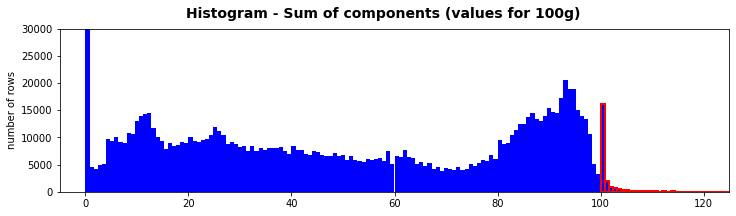

nb of rows where sum > 100:  11042
nb of rows where sum = 0:  285167
nb of rows where 0 > sum > 100:  1375952


In [185]:
# Checking for rows where sum of components > 100

m_out = df[sum_100g_cols].sum(axis='columns')>100
m_0 = df[sum_100g_cols].sum(axis='columns')==0
m_0_100 = df[sum_100g_cols].sum(axis='columns').between(0,100)
sum_100g = df[sum_100g_cols].sum(axis='columns')
hist = plt.hist(sum_100g, color='b', bins=500, label=('0 < sum < 100'))
ind = np.argmax(hist[1]>=100)
ax = plt.gca()
w = hist[1][1]-hist[1][0]
ax.bar(hist[1][ind:-1]+w/2, hist[0][ind:], ec = 'r',
       lw = 2, width=w,color='None', label=('sum > 100'))
ax.set(xlim=(-5,125), ylim=(0,30000))
fig = plt.gcf()
ax.set_ylabel('number of rows')
fig.suptitle('Histogram - Sum of components (values for 100g)',
             fontweight='bold', fontsize=14)
fig.set_size_inches(12,3)
plt.savefig('C_2_4_hist_sum_100g.png', dpi=400)
plt.show()
print("nb of rows where sum > 100: ", df[sum_100g_cols][m_out].shape[0])
print("nb of rows where sum = 0: ", df[sum_100g_cols][m_0].shape[0])
print("nb of rows where 0 > sum > 100: ", df[sum_100g_cols][m_0_100].shape[0])

In [0]:
# Putting sub-columns where sum of nutritional components exceed total to NaN
df.loc[:,sum_100g_cols] = df[sum_100g_cols].where(~m_out, other=np.nan)

In [187]:
speak('quantities per 100g cleaned')

### 2.5 'energy_100g' columns

Let's create a sub-dataframe for energy data and have a look on energy values.

In [188]:
# Creating a sub-dataframe for energy
energy_cols = ['energy_kj_100g', 'energy_kcal_100g',
               'energy_100g', 'energy_from_fat_100g']
main_energy_cols = ['energy_kj_100g', 'energy_kcal_100g',
               'energy_100g']
nut_comp_cols = ['fat_100g', 'carbohydrates_100g', 'proteins_100g',\
                 'alcohol_100g','fiber_100g', 'polyols_100g']
main_nut_comp_cols = ['fat_100g','carbohydrates_100g', 'proteins_100g']
df_e = df[energy_cols + nut_comp_cols].copy()
df_e.sample(3)

,energy_kj_100g,energy_kcal_100g,energy_100g,energy_from_fat_100g,fat_100g,carbohydrates_100g,proteins_100g,alcohol_100g,fiber_100g,polyols_100g
534420,nan,1192.00,1192.00,nan,6.00,46.00,9.50,nan,4.50,nan
349653,nan,2523.00,2523.00,nan,50.00,20.00,20.00,nan,13.30,nan
303603,nan,2510.00,2510.00,nan,46.67,26.67,20.00,nan,1.00,nan


In [189]:
df_e.describe()

,energy_kj_100g,energy_kcal_100g,energy_100g,energy_from_fat_100g,fat_100g,carbohydrates_100g,proteins_100g,alcohol_100g,fiber_100g,polyols_100g
count,102069.00,1051266.00,1122086.00,965.00,1103205.00,1102573.00,1104581.00,15413.00,422625.00,3328.00
mean,inf,34602344.00,inf,355.12,13.43,28.28,8.38,4.79,2.75,31.03
std,nan,35477069824.00,nan,524.30,17.42,28.08,9.60,9.54,4.27,33.73
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,397.00,427.00,423.00,42.00,0.60,3.57,1.20,0.00,0.00,4.00
50%,975.00,1109.00,1100.00,167.00,6.70,15.38,5.80,0.00,1.50,15.00
75%,1619.00,1674.00,1674.00,420.00,21.00,53.33,12.00,6.00,3.60,62.72
max,inf,36375088857088.00,inf,3830.00,100.00,100.00,100.00,100.00,100.00,100.00


[(-100.0, 20000.0)]

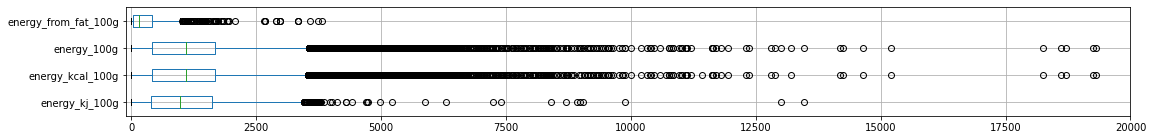

In [190]:
df_e[energy_cols].boxplot(vert=False, figsize=(18,2));
plt.gca().set(xlim=(-100,20000))

From this first overview we see that:

- The dispersion of energy values is almost the same for 'energy_kj_100g' and 'energy_kcal_100g', showing that a lot of values are not at the right place in either of the two columns, we'll try to determine the right unit.
- The unit of 'energy_100g' is not indicated, it will have to be infered.
- Some outliers must be dropped
- There are very few notna values of 'energy_from_fat_100g'


#### _2.5.a Getting rid of outliers_

We put to NaN all values not in [0,4000][<sup>*</sup>](#fn1)
___
<span id="fn1"> 
 _<sup>*</sup> A product cannot be more energetic than 100g of pure fat, which energy per 100g is 900kcal or 3765kJ.</span>_

In [191]:
# Dropping outliers with energy values not in [0,4000]
print("Total nb of NaN values before: ", df_e[energy_cols].isna().sum().sum())
for c in energy_cols:
    df_e.loc[:,c] = df_e[c].where(df_e[c].between(0,4000), other=np.nan)
print("Total nb of NaN values after: ", df_e[energy_cols].isna().sum().sum())

Total nb of NaN values before:  3271590
Total nb of NaN values after:  3276171


#### _2.5.b Calculating an energy_100g value from main nutritional components:_

Energy per 100g can be calculated or assessed if the data of fat, carbohydrate and proteins (which are the main source of energy in a product) are all available.

Let's get an overview of how much available data we have:


In [0]:
''' Function to count and print the number of missing values '''

def nb_rows_na(df, selcol, how):
  if how == 'all':
    ind = df[df[selcol].isna().all(axis=1)].index
  elif how == 'any':
    ind = df[df[selcol].isna().any(axis=1)].index
  else:
    ind=[]
    print("WARNING: 'how' must be either all or any")
  li_ind = ind.to_list()
  return len(li_ind), li_ind
  
def print_nb_rows_na(df, selcol, how):
  print("- columns: ", selcol, "\nnb of null containing rows (" + how + "): ", nb_rows_na(df, selcol, how)[0])

In [193]:
# Calculating the number of rows with not ANY energy OR (exclusive)
#  not ANY main nutrit. component filled
ind_no_energy = nb_rows_na(df_e, main_energy_cols, how='all')[1]
ind_all_comp_filled = df_e.drop(index=nb_rows_na(df_e,
                                                 main_nut_comp_cols,
                                                 'any')[1]).index.to_list()
ind_fat_filled = df_e.dropna(subset=['fat_100g']).index.to_list()
ind_no_en_AND_main_comp_filled = list(set(ind_no_energy) & set(ind_all_comp_filled))
print('not any energy filled : {}\nall main nutri. components filled : {}'\
      .format(len(ind_no_energy), len(ind_all_comp_filled)))
print('not any energy filled BUT all main nutri comp filled : {}'\
      .format(len(ind_no_en_AND_main_comp_filled)))

not any energy filled : 267166
all main nutri. components filled : 1098579
not any energy filled BUT all main nutri comp filled : 3235


Most of the rows have all three main nutritional components filled. 
We'll calculate energy for these.

We notice that nearly 25% of the rows have no energy filled. For less than 1% of them, it will however be possible to fill missing energy value with calculated one.

In [0]:
## Calculating energy and energy_from_fat from composition
# 0 - creating a dictionary for coefficient (kcal/g)
d_kcal = {'fat_100g': 9, 'carbohydrates_100g': 4, 'proteins_100g': 4,\
          'alcohol_100g': 7, 'fiber_100g': 1.9, 'polyols_100g': 2.4}
# 1 - stacking all _100g values
df_temp = df_e.reset_index().melt(id_vars='index', value_vars=nut_comp_cols,\
                                  var_name='nutri_comp', value_name='kcal_100g')
# 2 - creating a column of kcal/g coefficients
df_temp['coeff'] = (df_temp['nutri_comp'].map(d_kcal)).astype('float32')
# 3 - multiplying coeff and _100g values
df_temp['calc_energy_kcal_100g'] = df_temp['kcal_100g'].mul(df_temp['coeff'])
# 4 - summing the energy for each product (index)
calc_en = df_temp.groupby(df_temp['index'])['calc_energy_kcal_100g'].sum()
# 5 - deleting all outliers
calc_en[~calc_en.between(0,4000)] = np.nan
# 6 - extracting values of energy from fat
calc_fat_en = df_temp.groupby('nutri_comp').get_group('fat_100g')['calc_energy_kcal_100g']

In [0]:
# Inserting the new 'energy' columns in df_e, reordering columns
df_e.loc[ind_all_comp_filled,'calc_energy_kcal_100g'] = calc_en
df_e.loc[ind_all_comp_filled,'calc_energy_kj_100g'] = calc_en*4.184
df_e.loc[ind_fat_filled,'calc_energy_from_fat_kj_100g'] = calc_fat_en*4.184
cols = move_cat_containing(df_e.columns, ['energy'],'last')
df_e = df_e.reindex(columns=cols)
energy_cols += ['calc_energy_kcal_100g','calc_energy_kj_100g','calc_energy_from_fat_kj_100g']
del df_temp, calc_en, calc_fat_en

#### _2.5.c Determining the unit of energy columns_

Let's visualize the relationship between the different energy columns:

In [196]:
@interact
def plot_energy(x=energy_cols+['fat_100g'], y=energy_cols, coeff=(0,5,0.1)):
    fig, axs = plt.subplots(1)
    sns.scatterplot(data=df_e, x=x, y=y, s=15, ax=axs)
    x_reg, y_reg = np.linspace(0,4000,1000), np.linspace(0,4000,1000)*coeff
    axs.plot(x_reg, y_reg, '-r', zorder=1)
    fig.set_size_inches(12,3)
    axs.set(xlim=(0,4000), ylim=(0,4000))
    plt.show()

interactive(children=(Dropdown(description='x', options=('energy_kj_100g', 'energy_kcal_100g', 'energy_100g', …

In [197]:
@interact
def plot_energy_jg(x=energy_cols, y=energy_cols):
    jp = sns.jointplot(data=df_e, x=x, y=y, height=4, ratio=6,
                      kind='hexbin', xlim=(0,4000), ylim=(0,4000),
                      joint_kws=dict(gridsize=50),
                      marginal_kws=dict(bins=100))
    plt.show()

interactive(children=(Dropdown(description='x', options=('energy_kj_100g', 'energy_kcal_100g', 'energy_100g', …

It seems that, when both columns are filled :
- 'energy_kj_100g' is mainly the same as 'energy_100g' or as 'energy_kcal_100g'
- 'energy_kcal_100g' is mainly either 'energy_100g' or 4,18 * 'energy_100g'
- few 'energy_kj_100g' fit to 'calc_energy_kcal_100g'
- most of the 'energy_kcal_100g' fit to 'calc_energy_kcal_100g'
- In some cases the relationship between 'energy_kcal_100g' and 'energy_kj_100g' seems to be random.

Let's see the content of the three columns.

How often do they have 1, 2 or 3 values filled ? 

In [198]:
gb = df_e[main_energy_cols].notna().groupby(main_energy_cols)
display(gb.size())

energy_kj_100g  energy_kcal_100g  energy_100g
False           False             False           267166
                                  True               242
                True              False                2
                                  True           1017540
True            False             True             70616
                True              True             31428
dtype: int64

In [199]:
# printing a sample of each case
for n, i in gb.groups.items():
  display(n,df_e.loc[i,main_energy_cols].head(3))

(False, False, False)

,energy_kj_100g,energy_kcal_100g,energy_100g
1,nan,nan,nan
2,nan,nan,nan
4,nan,nan,nan


(False, False, True)

,energy_kj_100g,energy_kcal_100g,energy_100g
792,nan,nan,1533.00
141546,nan,nan,377.00
148035,nan,nan,0.00


(False, True, False)

,energy_kj_100g,energy_kcal_100g,energy_100g
1099948,nan,1800.00,nan
1286731,nan,3467.00,nan


(False, True, True)

,energy_kj_100g,energy_kcal_100g,energy_100g
0,nan,1569.00,1569.00
5,nan,88.00,88.00
6,nan,251.00,251.00


(True, False, True)

,energy_kj_100g,energy_kcal_100g,energy_100g
3,936.00,nan,936.00
158,1513.00,nan,1513.00
272,2179.00,nan,2179.00


(True, True, True)

,energy_kj_100g,energy_kcal_100g,energy_100g
373,2318.00,2347.00,2318.00
374,1104.00,1121.00,1104.00
1431,137.00,138.00,137.00


When there is more than one value filled, are filled values always the same ?

In [200]:
# Shows nb of rows where all values are the same 
for n, i in gb.groups.items():
    # median=mean only if the values are the same
    test = (df_e.loc[i,main_energy_cols].mean(axis=1).eq(
            df_e.loc[i,main_energy_cols].median(axis=1)))
    print(n,': ', test.sum(),'/', len(i))

(False, False, False) :  0 / 267166
(False, False, True) :  242 / 242
(False, True, False) :  2 / 2
(False, True, True) :  1017540 / 1017540
(True, False, True) :  70616 / 70616
(True, True, True) :  2905 / 31428


- Values are always the same when two columns are filled
- Values are not the same only when the three values are filled.

We are going to work on the 'energy_100g' column.

If 'energy_100g' value is NaN:
1. When only 'energy_kj_100g' or 'energy_kcal_100g' (not both) is filled, we copy the value in 'energy_100g'.
2. When both are filled, we take the value that matches best with one of the calculated columns if it exists, else we take the larger value.

If 'energy_100g' value is filled:
1. We keep this value if only 'energy_kj_100g' or 'energy_kcal_100g' (not both) is filled.
2. When both are filled, we overwrite the value of 'energy_100g' with the value that matches best the calculated columns if it exists, else we keep the existing value.

In [201]:
# Only 'energy_kcal_100g' filled
print('----False, True, False----')
try:
    ind = gb.get_group((False, True, False)).index
    df_e.loc[ind,'energy_100g'] = df_e.loc[ind,'energy_kcal_100g']
    print(f"{len(ind)} values from 'energy_kcal_100g' successfully copied to 'energy_100g'")
except:
    print("!!!: check out : this group may not exist")

----False, True, False----
2 values from 'energy_kcal_100g' successfully copied to 'energy_100g'


In [202]:
# Only 'energy_kj_100g' filled
print('----True, False, False----')
try:
    ind = gb.get_group((True, False, False)).index
    df_e.loc[ind,'energy_100g'] = df_e.loc[ind,'energy_kj_100g']
    print(f"{len(ind)} values from 'energy_kj_100g' copied to 'energy_100g'")
except:
    print("!!!: check out : this group may not exist")

----True, False, False----
!!!: check out : this group may not exist


In [203]:
# All three columns filled
print('----True, True, True----')
try:
    s_df = gb.get_group((True, True, True))
    ind = s_df.index
    # if calculated value not null
    calc_kj = df_e.loc[ind,'calc_energy_kj_100g']+0.001
    calc_kcal = df_e.loc[ind,'calc_energy_kcal_100g']+0.001
    kj_rat = np.abs(1-df_e.loc[ind,'energy_kj_100g'].div(calc_kj))
    kcal_rat = np.abs(1-df_e.loc[ind,'energy_kcal_100g'].div(calc_kcal))
    ser = pd.DataFrame([kj_rat, kcal_rat],
                        index=['energy_kj_100g','energy_kcal_100g']).idxmin(axis=0)
    for n, i in s_df.groupby(ser).groups.items(): # take the one closer to calc
        df_e.loc[i,'energy_100g'] = df_e.loc[i,n]
        print(f"{len(i)} values from",n ,
            "successfully overwritten to 'energy_100g'")
    # if no calculated value
    i_no_calc = calc_kj[calc_kj.isna()].index
    print(f"{len(i_no_calc)} unchanged values of 'energy_100g'\
    (missing calculated value)")
except:
    print("check out : this group may not exist")
#####

----True, True, True----
195 values from energy_kcal_100g successfully overwritten to 'energy_100g'
30929 values from energy_kj_100g successfully overwritten to 'energy_100g'
304 unchanged values of 'energy_100g'    (missing calculated value)


In [204]:
# 'energy_kj_100g' and 'energy_kcal_100g' filled
print('----True, True, False----')
try:
    s_df = gb.get_group((True, True, False))
    ind = s_df.index
    # if calculated value not null
    calc_kj = df_e.loc[ind,'calc_energy_kj_100g']+0.001
    calc_kcal = df_e.loc[ind,'calc_energy_kcal_100g']+0.001
    kj_rat = np.abs(1-df_e.loc[ind,'energy_kj_100g'].div(calc_kj))
    kcal_rat = np.abs(1-df_e.loc[ind,'energy_kcal_100g'].div(calc_kcal))
    ser = pd.DataFrame([kj_rat, kcal_rat],
                        index=['energy_kj_100g','energy_kcal_100g']).idxmin(axis=0)
    for n, i in s_df.groupby(ser).groups.items(): # take the one closer to calc
        df_e.loc[i,'energy_100g'] = df_e.loc[i,n]
        print(f"{len(i)} values from",n ,
            "successfully overwritten to 'energy_100g'")
    # if no calculated value
    i_no_calc = calc_kj[calc_kj.isna()].index
    df_e.loc[i_no_calc,'energy_100g'] = \
                df_e.loc[i_no_calc,['calc_energy_kj_100g',
                                    'calc_energy_kcal_100g']].max()
    print(f"{len(i_no_calc)} max values (kcal or kj) copied to 'energy_100g'\
    (missing calculated value)")
except:
    print("check out : this group may not exist")

----True, True, False----
check out : this group may not exist


Let's determine now the unit of the values of 'energy_100g'.

There are 4 cases regarding the availability of values in 'energy_100g' and 'calc_energy_kj_100g' :
0. **none**: nothing to do
1. **only 'calc_energy_kj_100g'**: fill using calculated values
2. **both**: determine if 'energy_100g' is closer from the value of 'calc_energy_kj_100g' or 'calc_energy_kcal_100g' to find the 
3. **only 'energy_100g'**: build a ML model to assess the unit, considering available values like main nutritional components, nutriscore and category.

In [205]:
# Classifying the cases

gb = df_e[['energy_100g', 'calc_energy_kj_100g']].notna()\
          .groupby(['energy_100g', 'calc_energy_kj_100g'])
gb.size()

energy_100g  calc_energy_kj_100g
False        False                   263931
             True                      3235
True         False                    24484
             True                   1095344
dtype: int64

In [206]:
# 1- Case where calculated values are available but not 'energy_100g'
# -> We recopy calculated values

print('----False, True----')
try:
    indFT = gb.get_group((False, True)).index
    df_e.loc[indFT,['energy_kj_100g_F', 'energy_kcal_100g_F']] = \
          df_e.loc[indFT,['calc_energy_kj_100g', 'calc_energy_kcal_100g']]
    print(f"{len(indFT)} calculated values successfully written to\
'energy_kj_100g_F' and 'energy_kcal_100g_F'")
except:
    print("!!!: check out : this group may not exist")

----False, True----
!!!: check out : this group may not exist


In [207]:
# 2 - Case where 'energy_100g' and calculated values are available
# -> Determining which of 'calc_energy_k_100g' or 'calc_energy_kcal_100g'
# is best matching the values of 'energy_100g'

print('----True, True----')
try:
    indTT = gb.get_group((True, True)).index
    calc_kj = df_e.loc[indTT,'calc_energy_kj_100g']+0.001
    calc_kcal = df_e.loc[indTT,'calc_energy_kcal_100g']+0.001
    kj_rat = np.abs(1-df_e.loc[indTT,'energy_100g'].div(calc_kj))
    kcal_rat = np.abs(1-df_e.loc[indTT,'energy_100g'].div(calc_kcal))
    serTT = pd.DataFrame([kj_rat, kcal_rat],
                        index=['energy_kj_100g','energy_kcal_100g']).idxmin(axis=0)
    for n, i in df_e.groupby(serTT).groups.items(): # take the one closer to calc
        df_e.loc[i,n+'_F'] = df_e.loc[i,'energy_100g']
        print(f"{len(i)} values from 'energy_100g'", "successfully written to", n+'_F')
except:
    print("!!!: check out : this group may not exist")

----True, True----
11290 values from 'energy_100g' successfully written to energy_kcal_100g_F
1084054 values from 'energy_100g' successfully written to energy_kj_100g_F


In [208]:
s1 = ['a', 'b', np.nan, 'a', 'a']
s2 = [1,2,5,7,8]
truc = pd.DataFrame( {'s1': s1, 's2': s2})
pd.get_dummies(truc, columns= ['s1'] )

,s2,s1_a,s1_b
0,1,1,0
1,2,0,1
2,5,0,0
3,7,1,0
4,8,1,0


In [0]:
# 3- Case where 'energy_100g' is available but not calculated values
# -> Functions building a model to determine the most probable unit

def class_unit_y_preproc(dfy, indTT, serTT) :
    df_y = dfy.copy()
    # y preprocessing
    df_y = df_y.map({'energy_kj_100g': 0, 'energy_kcal_100g': 1})
    print("--v_counts on df_y  (0: kj, 1: kcal)\n", df_y.value_counts())
    y = df_y.values
    print("--y shape:\n", y.shape)
    return y

def class_unit_fit_predict(X,y):
    Xtr, Xte, ytr, yte = train_test_split(X, y)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(Xtr, ytr)
    print('------- knn perf -------')
    ypr = knn.predict(Xte)
    print("- accuracy: ", metrics.accuracy_score(yte, ypr))
    print("- confusion matrix TN (kj), FP, FN , TP (kcal):\n",\
        np.ravel(metrics.confusion_matrix(yte, ypr)))
    # Comparison with naive baselines
    for s in ['stratified', 'most_frequent', 'prior', 'uniform']:
        print('------- dummy ' + s + ' -------')
        dum = DummyClassifier(strategy=s).fit(Xtr, ytr)
        ypr_dum = dum.predict(Xte)
        print("- accuracy: ", metrics.accuracy_score(yte, ypr_dum))
        print("- confusion matrix: ",
                    np.ravel(metrics.confusion_matrix(yte, ypr_dum)))
    return knn

In [0]:
def class_unit_X_preproc(df, fill_strat='mean', fill_val=0):

    dfX = df.copy()
    Q_cols = dfX.select_dtypes(include=['number']).columns
    C_cols = dfX.select_dtypes(include=['object']).columns

    print("--nb of nan values to be filled with "+str(fill_strat)+" / total nb of cells:",
          dfX.isna().sum().sum(),"/", dfX.shape[0]*dfX.shape[1])

    # Fills nan with categorical mean
    if fill_strat == 'cat_median':
        print("cat_median doesn't work presently")
        # Problème - A REPARER EVENTUELLEMENT
        # # -- Replacing bugging gb.transform(lambda x: x.fillna(median(x)))
        # med_tab, n_tab = pd.DataFrame([]), [] # keeps track of nb of nan in each pnns1 category
        # for n, gr in dfX.groupby('pnns1'):
        #     median_gr = gr.agg(np.nanmedian)
        #     dfX.loc[gr.index, Q_cols] = gr.fillna(lambda x: np.median(x))[Q_cols]
        #     # n_tab.append(n)
        #     # dfX = pd.concat([dfX,gr.fillna(lambda x: np.median(x))], axis=0)
        #     # med_tab = pd.concat([med_tab, median_gr.to_frame()], axis=1)
        # # med_tab.columns = n_tab
        # # print('-- (cat_median) - median of each category:\n')
        # # display(med_tab)
    else:
        # Fills nan with constant
        if fill_strat == 'constant':
            simp = SimpleImputer(strategy=fill_strat, fill_value=fill_val)
        # Fills nan with chosen fill_strat (mean, median or most_frequent)
        else:
            simp = SimpleImputer(strategy=fill_strat)
        dfX[Q_cols] = simp.fit_transform(dfX[Q_cols])
        print("--columns filled by sklearn.SimpleImputer with:")
        print(simp.statistics_)
   
    dfX = pd.get_dummies(dfX, columns=['pnns1'])
    X = dfX.values
    print('num of nan after:', dfX.isna().sum().sum())
    return X

In [218]:
# 3- Case where 'energy_100g' is available but not calculated values
# -> Using a classification model to determine the unit

print('----True, False----')
# try:
indTF = gb.get_group((True, False)).index
model_cols = ['pnns1'] + main_nut_comp_cols + ['nutriscore_fr']
df_X = df.loc[indTT,model_cols]
print('shape before function',df_X.shape)
# Training the model with rows where both energy_100g and calc values are avail.
print('oooooooo DATA PREPROCESSING oooooooo')
# Preprocessing data
X = class_unit_X_preproc(df_X, fill_strat='mean') # fill_strat='constant', fill_val=0
df_y = serTT.loc[indTT]
y = class_unit_y_preproc(df_y, indTT, serTT)
print('oooooooo TRAINING THE MODEL oooooooo')
knn = class_unit_fit_predict(X,y)
# Predicting kj or kcal when only energy_100g is available
print('oooooooo PREDICTING WITH THE MODEL oooooooo')
df_X_ = df.loc[indTF,model_cols]
X_ = class_unit_X_preproc(df_X_, fill_strat='mean')
ypr_ = knn.predict(X_)
d_conv = {0: 'energy_kj_100g', 1: 'energy_kcal_100g'}
ser = pd.Series([d_conv[y] for y in ypr_], index=indTF)

# Imputing energy_100g value or calculated value
print("--df_X_ nan values to be filled / shape:",
           df_X_.isna().sum().sum(),"/", df_X_.shape)
for n, i in df_e.groupby(ser).groups.items():
    df_e.loc[i,n+'_F'] = df_e.loc[i,'energy_100g']
    print(f"{len(i)} values from 'energy_100g'", "successfully written to", n+'_F')
print(f"{len(indTF)} calculated values successfully written to\
'energy_kj_100g_F' or 'energy_kcal_100g_F'")

# except:
#     print("!!!: check out : this group may not exist")

----True, False----
shape before function (1095344, 5)
oooooooo DATA PREPROCESSING oooooooo
--nb of nan values to be filled with mean / total nb of cells: 1120873 / 5476720
--columns filled by sklearn.SimpleImputer with:
[13.41438215 28.29804518  8.37641325  9.11950471]
num of nan after: 0
--v_counts on df_y  (0: kj, 1: kcal)
 0    1084054
1      11290
dtype: int64
--y shape:
 (1095344,)
oooooooo TRAINING THE MODEL oooooooo
------- knn perf -------
- accuracy:  0.9898917600315518
- confusion matrix TN (kj), FP, FN , TP (kcal):
 [270683    233   2535    385]
------- dummy stratified -------
- accuracy:  0.979407382520925
- confusion matrix:  [268164   2752   2887     33]
------- dummy most_frequent -------
- accuracy:  0.9893366832702786
- confusion matrix:  [270916      0   2920      0]
------- dummy prior -------
- accuracy:  0.9893366832702786
- confusion matrix:  [270916      0   2920      0]
------- dummy uniform -------
- accuracy:  0.5015008983479162
- confusion matrix:  [135851 

In [219]:
# Filling the missing energy column (either in kj or kcal)

df_e['energy_kj_100g_FF'] = df_e['energy_kj_100g_F'].fillna(df_e['energy_kcal_100g_F']*4.18)
df_e['energy_kcal_100g_FF'] = df_e['energy_kcal_100g_F'].fillna(df_e['energy_kj_100g_F']/4.18)
df_e.drop(columns=['energy_kj_100g_F', 'energy_kcal_100g_F'],
                  inplace=True)
df_e = df_e.rename(columns={'energy_kj_100g_FF': 'energy_kj_100g_F',
                     'energy_kcal_100g_FF': 'energy_kcal_100g_F'})
energy_cols += ['energy_kj_100g_F','energy_kcal_100g_F']
df_e.sample(3)

,fat_100g,carbohydrates_100g,proteins_100g,alcohol_100g,fiber_100g,polyols_100g,energy_kj_100g,energy_kcal_100g,energy_100g,energy_from_fat_100g,calc_energy_kcal_100g,calc_energy_kj_100g,calc_energy_from_fat_kj_100g,energy_kj_100g_F,energy_kcal_100g_F
700103,16.00,72.00,8.00,nan,1.60,nan,nan,1946.00,1946.00,nan,467.04,1954.10,602.50,1946.00,465.55
891325,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1368450,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [220]:
# Checking the relationship between the energy columns

@interact
def plot_energy(x=energy_cols+['fat_100g'], y=energy_cols, coeff=(0,5,0.1)):
    fig, axs = plt.subplots(1)
    sns.scatterplot(data=df_e, x=x, y=y, s=15, ax=axs)
    x_reg, y_reg = np.linspace(0,4000,1000), np.linspace(0,4000,1000)*coeff
    axs.plot(x_reg, y_reg, '-r', zorder=1)
    fig.set_size_inches(12,3)
    axs.set(xlim=(0,4000), ylim=(0,4000))
    plt.show()

interactive(children=(Dropdown(description='x', options=('energy_kj_100g', 'energy_kcal_100g', 'energy_100g', …

Now we need to delete new possible generated outliers.

In [221]:
# Dropping outliers
print("Total nb of NaN values before: ", df_e[energy_cols].isna().sum().sum())
df_e.loc[:,'energy_kj_100g_F'] = \
    df_e['energy_kj_100g_F'].where(df_e['energy_kj_100g_F'].between(0,3765))
df_e.loc[:,'energy_kcal_100g_F'] = \
    df_e['energy_kcal_100g_F'].where(df_e['energy_kcal_100g_F'].between(0,900))
print("Total nb of NaN values after: ", df_e[energy_cols].isna().sum().sum())

Total nb of NaN values before:  4671120
Total nb of NaN values after:  4682144


Let's now merge the new features in df.

In [222]:
# Merging df_e with df, reordering the columns
print("df before: ", df.shape,
      " | df_e: ", df_e.shape)
df = df.merge(df_e[['energy_kj_100g_F','energy_kcal_100g_F',
                    'calc_energy_from_fat_kj_100g']],
                      how = 'left',  left_index=True, right_index=True)
df.drop(columns=['energy_from_fat_100g', 'energy_kj_100g',
                 'energy_kcal_100g', 'energy_100g'], inplace=True)
df = df.rename(columns={'energy_kj_100g_F': 'energy_kj_100g',
                        'energy_kcal_100g_F': 'energy_kcal_100g',
                        'calc_energy_from_fat_kj_100g': 'energy_from_fat_kj_100g'})
df = df.reindex(columns=move_cat_containing(df.columns,['energy'], 'first'))
print("df after: \n", df.shape)
# Showing df shape and column order
for i,c in enumerate(df.columns):
  print('\n'+c, end=' | ') if (i) % 6 == 0  else print(c, end=' | ')

df before:  (1386994, 54)  | df_e:  (1386994, 15)
df after: 
 (1386994, 53)

code | code_val | categories_main | categories_tuple | url | main_category | 
quantity_unit | quantity_num | serving_quantity | quantity_type | labels_main | labels_tuple | 
pnns2 | pnns1 | creator | created_datetime | product_name | countries_main | 
brands_main | packaging_main | packaging_tuple | brands_tuple | allergens_main | allergens_tuple | 
countries_tuple | ingredients_text | additives_main | traces_main | traces_tuple | additives_tuple | 
additives_n | nutriscore_fr | nutrigrade | nutriscore | nova_group | ingredients_from_palm_oil_n | 
ingredients_that_may_be_from_palm_oil_n | fat_100g | saturated_fat_100g | carbohydrates_100g | sugars_100g | polyols_100g | 
fiber_100g | proteins_100g | salt_100g | sodium_100g | alcohol_100g | fruits_vegetables_nuts_100g | 
energy_from_fat_kj_100g | energy_kcal_100g | energy_kj_100g | fruits_vegetables_nuts_estimate_100g | collagen_meat_protein_ratio_100g | 

In [223]:
energy_cols = df.columns[df.columns.str.contains('energ')]
df[energy_cols].describe()

,energy_from_fat_kj_100g,energy_kcal_100g,energy_kj_100g
count,1103205.00,1114309.00,1114323.00
mean,505.96,270.44,1130.45
std,656.22,186.23,778.49
min,0.00,0.00,0.00
25%,22.59,102.15,427.00
50%,252.30,262.20,1096.00
75%,790.78,400.48,1674.00
max,3765.60,900.00,3764.00


In [0]:
# Dropping columns that won't be used anymore

df = df.drop(columns=['energy_kcal_100g', 'alcohol_100g', 'polyols_100g'])

In [226]:
print(df.shape)
print_null_pct(df)

(1386994, 50)
nb of null:  27718770 
pct of null:  40.0


In [227]:
speak('energy columns cleaned')

### 2.6 Category columns

In order to try to reconstruct missing nutriscores, we need to assess the category of food.
Nutriscore formula is different for :
- beverages/solid food
- fats
- fruits and vegetables
- cheese
Let's browse category columns to find a good indicator of these categories.

#### 2.6.* Unknowns

Lets' check at first the content of the unknown columns in pnns1 and pnns2. 

In [228]:
# How much of unknowned is missing in pnns1/unknown ?

print('cat of pnns2/unknown in pnns1:\n',
     df[df['pnns1']=='unknown']['pnns2'].value_counts())
print('cat of pnns1/unknown in pnns2: ',
      df[df['pnns2']=='unknown']['pnns1'].value_counts())

cat of pnns2/unknown in pnns1:
 Series([], Name: pnns2, dtype: int64)
cat of pnns1/unknown in pnns2:  Series([], Name: pnns1, dtype: int64)


In [229]:
# Getting indices of unknown

i_unkn = df[df['pnns1']=='unknown'].index # 810376
i_unkn.shape

(0,)

#### **2.6.a Beverages**

Let's find one or several categories to find beverages.
A glance to pnns columns suggests:
* **pnns1** : 'beverages'
* **pnns2** : 'alcoholic beverages', 'milk and yogurt', 'fruit juices', 'fruit nectars', 'plant-based milk substitutes', 'teas and herbal teas and coffees', 'unsweetened beverages', 'sweetened beverages', 'artificially sweetened beverages', 'waters and flavored waters'

In [230]:
# Which categories of 'pnns2' are in 'pnns1'/'beverages' ?

df.groupby('pnns1').get_group('beverages')['pnns2'].unique()

array(['fruit juices', 'sweetened beverages', 'unsweetened beverages',
       'plant-based milk substitutes', 'teas and herbal teas and coffees',
       'artificially sweetened beverages', 'waters and flavored waters',
       'fruit nectars'], dtype=object)

we notice that __'pnns1'/'beverages'__ seems quite inclusive, but it is missing:
- 'milk', and 
-'alcoholic beverages'

After verification in the nutriscore documentation, nutriscore does not apply to alcoholic beverages.

Furthermore, milk is not considered as 'beverage' for the purpose of calculating nutriscore.

We do not add them.

In [231]:
# The subcategories of 'pnns1'/'beverages' are they all contained 
# in above-listed categories from pnns2 ? 

df[df['pnns2'].isin(['fruit juices', 'sweetened beverages', 'unsweetened beverages',
       'plant-based milk substitutes', 'teas and herbal teas and coffees',
       'artificially sweetened beverages', 'waters and flavored waters',
       'fruit nectars'])].shape, df[df['pnns1']=='beverages'].shape
# -> ((57472, 108), (57472, 108)) Yes, same shape

((57772, 50), (57772, 50))

In [0]:
# # To find the number of milk products and alcoholic beverages
# print('alcoholic bev.: ', df[df['pnns2']=='alcoholic beverages'].shape)
# print('milk and yogurt: ', df[df['pnns2']=='milk and yogurt'].shape)
# m1 = df['pnns2']=='milk and yogurt'
# m2 = df['quantity_type']=='vol'
# print('milk and yogurt (unit=vol): ', df[m1&m2].shape)

We'll consider as beverages: 
- pnns1 : 'beverages'
and we'll add :
- 'pnns2'/'alcoholic beverages'
- 'pnns2'/'milk and yogurt' when the 'quantity_unit' is 'vol'

In [0]:
# Index selection for nutriscore calculation

i_bev = df.groupby('pnns1').get_group('beverages').index # 57472
# i_bev = i_bev.append(df.groupby('pnns2').get_group('alcoholic beverages').index)
# i_bev = i_bev.append(df[m1&m2].index)
i_not_bev = pd.Index(set(df.index)-set(i_bev)-set(i_unkn))
i_wat = df[df['pnns2']=='waters and flavored waters'].index

#### **2.6.b Fruits and vegetables**

Let's find one or several categories to find fruits and vegetables.
A glance to pnns columns suggests:
* **pnns1** : 'fruits and vegetables'
* **pnns2** : 'vegetables', 'potatoes', 'soups', 'nuts', 'fruits', 'dried fruits'

In [234]:
# Which categories of 'pnns2' are in 'pnns1'/'fruits and vegetables' ?

df.groupby('pnns1').get_group('fruits and vegetables')['pnns2'].unique()

array(['fruits', 'dried fruits', 'vegetables', 'soups'], dtype=object)

we notice that __'pnns1'/'fruits and vegetables'__ seems quite inclusive, but it is missing 'potatoes' and 'nuts'.

However, potatoes must not be added as it is specified in nutriscore documentation as excluded from 'fruits and vegetables' class, along with yam and manioc.


In [235]:
# The subcategories of 'pnns1'/'fruits and vegetables' are they all contained 
# in above-listed categories from pnns2 ? 

df[df['pnns2'].isin(['fruits', 'dried fruits',
                         'vegetables', 'soups'])].shape,\
                         df[df['pnns1']=='fruits and vegetables'].shape
# -> ((50756, 108), (50756, 108)) Yes, same shape

((50986, 50), (50986, 50))

In [236]:
# How much of beverages is missing in pnns1/fruits and vegetables ?

print('potatoes: ', df[df['pnns2']=='potatoes'].shape)
print('nuts: ', df[df['pnns2']=='nuts'].shape)

potatoes:  (2275, 50)
nuts:  (5525, 50)


In [0]:
# Index selection for nutriscore calculation

i_fr_veg = df.groupby('pnns1').get_group('beverages').index # 57472
# i_fr_veg = i_fr_veg.append(df.groupby('pnns2').get_group('potatoes').index)
i_fr_veg = i_fr_veg.append(df.groupby('pnns2').get_group('nuts').index)
i_not_fr_veg = pd.Index(set(df.index)-set(i_fr_veg)-set(i_unkn))

#### **2.6.c Fats**

The only category corresponding is **pnns2/fats**.

In [0]:
# Index selection for nutriscore calculation

i_fats = df.groupby('pnns2').get_group('fats').index
i_not_fats = pd.Index(set(df.index)-set(i_fats))

#### **2.6.d Cheese**

The only category corresponding is **pnns2/cheese**.

In [0]:
# Index selection for nutriscore calculation

i_chees = df.groupby('pnns2').get_group('cheese').index
i_not_chees = pd.Index(set(df.index)-set(i_chees)-set(i_unkn))

In [240]:
print(df.shape)
print_null_pct(df)

(1386994, 50)
nb of null:  27718770 
pct of null:  40.0


### 2.7 'nutriscore' columns

#### _2.7.a Checking nutriscore columns_

In [242]:
# Checking if there are rows where 'nutriscore' and 'nutriscore_fr' are not null
# and different from one another

nutri_cols = df.columns[df.columns.str.contains('nutri')]
print(nutri_cols)
cond = df['nutriscore']==df['nutriscore_fr']
gb = df.dropna(how='all', subset=['nutriscore', 'nutriscore_fr']).groupby(cond)
print(gb.size())
display(gb.get_group(False)[['nutriscore', 'nutriscore_fr']])

Index(['nutriscore_fr', 'nutrigrade', 'nutriscore'], dtype='object')
False         9
True     567981
dtype: int64


,nutriscore,nutriscore_fr
236776,nan,11.00
623606,nan,-3.00
636333,nan,22.00
682080,nan,0.00
710649,nan,22.00
719466,nan,3.00
940110,nan,-6.00
1041605,nan,1.00
1350501,nan,0.00


'nutriscore_fr' has more values.
We drop 'nutriscore', and change 'nutriscore_fr' to 'nutriscore'.

In [243]:
# Dropping 'nutriscore' and changing name of 'nutriscore_fr'

print('df before: ', df.shape)
df = df.drop(columns='nutriscore')\
       .rename(columns={'nutriscore_fr': 'nutriscore'})
print('df after: ', df.shape)

df before:  (1386994, 50)
df after:  (1386994, 49)


Nutriscore should be between -15 and 40.

count   567990.00
mean         9.19
std          8.93
min        -15.00
25%          1.00
50%         10.00
75%         16.00
max         40.00
Name: nutriscore, dtype: float64


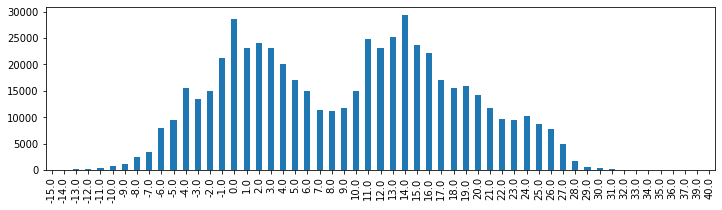

In [244]:
# Checking for outliers

nut_vals = df['nutriscore'].value_counts().sort_index()
print(df['nutriscore'].describe())
nut_vals.plot.bar()
plt.gcf().set_size_inches(12,3)

In [245]:
## Correspondance of nutriscores and nutrigrades

nutri_verif = pd.Series(index=df.index, dtype='object')
# beverages
nutri_verif.loc[i_bev] = pd.cut(df.loc[i_bev,'nutriscore'],
                     [-500,1,5,9,500], labels=list('bcde')).astype('object')
nutri_verif.loc[i_wat] = 'a'
# others
nutri_verif.loc[i_not_bev] = pd.cut(df.loc[i_not_bev,'nutriscore'],
                [-500,-1,2,10,18,500], labels=list('abcde')).astype('object')
# unknown (to be sure...)
nutri_verif.loc[i_unkn] = np.nan

df['nutri_verif'] = nutri_verif
print("nutri_verif notna/total", nutri_verif.notna().sum(),
      '/',nutri_verif.shape[0])
print("nutriscore notna/total", df['nutriscore'].notna().sum(),'/',df.shape[0])

nutri_verif notna/total 570825 / 1386994
nutriscore notna/total 567990 / 1386994


Is there a nutriscore without nutrigrade and vice-versa?

In [246]:
# Exploring cases as regarding nan values in 'nutriscore' and 'nutrigrade'

gb = df[['nutriscore','nutrigrade']].notna().groupby(['nutriscore','nutrigrade'])
print(gb.size())
df[['nutriscore','nutrigrade','nutri_verif',
    'pnns1', 'pnns2']].loc[gb.get_group((True, False)).index]

nutriscore  nutrigrade
False       False         819004
True        False              9
            True          567981
dtype: int64


,nutriscore,nutrigrade,nutri_verif,pnns1,pnns2
236776,11.00,NaN,d,fish meat eggs,meat
623606,-3.00,NaN,a,fruits and veget...,vegetables
636333,22.00,NaN,e,sugary snacks,biscuits and cakes
682080,0.00,NaN,b,fish meat eggs,fish and seafood
710649,22.00,NaN,e,NaN,NaN
719466,3.00,NaN,c,beverages,fruit juices
940110,-6.00,NaN,a,cereals and pota...,cereals
1041605,1.00,NaN,b,composite foods,one-dish meals
1350501,0.00,NaN,b,milk and dairy p...,milk and yogurt


No nutrigrade without nutriscore, but some nutriscores without nutrigrades.

When pnns categories are not nan, we take the calculated value.

In [0]:
# Filling missing nutrigrade with values from nutri_verif

df.loc[gb.get_group((True, False)).index, 'nutrigrade'] =\
          df.loc[gb.get_group((True, False)).index, 'nutri_verif']

Is there a lot of nutrigrades not matching our assessed values ?

among beverages:  24922 
among others:  800024


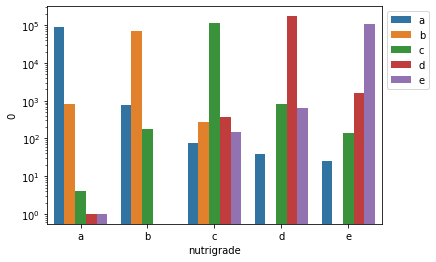

In [248]:
# Showing the misplaced nutrigrades

gb = df.groupby(df['nutrigrade']==df['nutri_verif'])
print('among beverages: ', gb.get_group(False).index.isin(i_bev).sum(),\
'\namong others: ', gb.get_group(False).index.isin(i_not_bev).sum())
res = df.groupby(by=['nutrigrade', 'nutri_verif']).size().reset_index()
sns.barplot(data=res, x='nutrigrade', hue='nutri_verif', y=0, dodge=True)
ax = plt.gca()
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,1));

Since misplaced nutrigrades are quite rare, we decide to replace them by the result of our alogrithm.

In [0]:
# Replacing wrong nutrigrades

df['nutrigrade'] = df['nutri_verif'].where((df['nutrigrade']!=df['nutri_verif'])&\
                                           (df['nutri_verif'].notna()),
                                           other=df['nutrigrade'])

In [0]:
# Drop nutri_verif

df.drop(columns='nutri_verif', inplace=True)

#### _2.7.b Calculation of preliminary values for Nutriscore calculation_

The nutriscore can be calculated provided enough data.
______
See [HERE](https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique-en) for more information.

We'll need the fruits, vegetables and nuts content (percent). Let's check the values of 'fruits-vegetables-nuts_100g' and fruits-vegetables-nuts-estimate_100g' columns.

(19297, 2) (8274,) (11226,) 



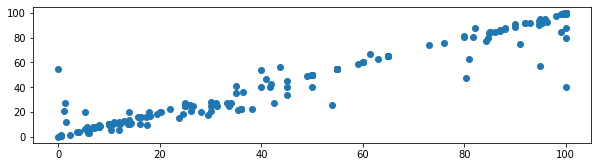

,fruits_vegetables_nuts_100g,fruits_vegetables_nuts_estimate_100g
867286,nan,8.06
514211,nan,55.00
558756,0.00,nan
1015972,12.00,nan
761029,7.35,nan


In [252]:
# Plotting combined 'fruits-vegetables-nuts' column

df_f_v = df[['fruits_vegetables_nuts_100g',
    'fruits_vegetables_nuts_estimate_100g']].dropna(how='all')
print(df_f_v.shape, df['fruits_vegetables_nuts_100g'].dropna().shape,
       df['fruits_vegetables_nuts_estimate_100g'].dropna().shape, '\n')
plt.scatter(df_f_v.iloc[:,0], df_f_v.iloc[:,1])
plt.gcf().set_size_inches(10,2.5)
plt.show()
df_f_v.sample(5)

Let's increase the content of 'fruits-vegetables-nuts_100g' by combining the two columns (which are most of the time exclusively filled) in order to increase the data.

NB: We'll set priority to the 'fruits-vegetables-nuts_100g' column on the 'fruits-vegetables-nuts-estimate_100g' column if both values are available and drop the original columns.

In [0]:
# Adding combined fruits-vegetables-nuts columns to df

df['fruit_veg_nut_100g'] = df['fruits_vegetables_nuts_100g']\
                     .combine_first(df['fruits_vegetables_nuts_estimate_100g'])
df[df['fruit_veg_nut_100g'].notna()].sample(5)
del df['fruits_vegetables_nuts_100g'], df['fruits_vegetables_nuts_estimate_100g']

Let's create a sub_dataframe with nutriscore facts.

In [0]:
df_n = df[['nutriscore', 'nutrigrade', 'quantity_type', 'fruit_veg_nut_100g']].copy('deep')

Let's add columns stating if the product belongs to categories: beverage, fruits and vegetables, fats and cheeses.

In [257]:
# Column stating (bool) if beverage or not 

df_n = df_n.assign(bev_b=False)
df_n.loc[i_bev,'bev_b'] = True
df_n['bev_b'].value_counts(), df_n.shape

(False    1329222
 True       57772
 Name: bev_b, dtype: int64, (1386994, 5))

In [258]:
# Column stating (bool) if fruits and vegetables or not 

df_n = df_n.assign(fr_veg_b=False)
df_n.loc[i_fr_veg,'fr_veg_b'] = True
df_n['fr_veg_b'].value_counts(), df_n.shape

(False    1323697
 True       63297
 Name: fr_veg_b, dtype: int64, (1386994, 6))

In [259]:
# Column stating (bool) if fats or not 

df_n = df_n.assign(fats_b=False)
df_n.loc[i_fats,'fats_b'] = True
df_n['fats_b'].value_counts(), df_n.shape

(False    1371094
 True       15900
 Name: fats_b, dtype: int64, (1386994, 7))

In [260]:
# Column stating (bool) if cheese or not 

df_n = df_n.assign(chees_b=False)
df_n.loc[i_chees,'chees_b'] = True
df_n['chees_b'].value_counts(), df_n.shape

(False    1351376
 True       35618
 Name: chees_b, dtype: int64, (1386994, 8))

Now, let's calculate sub A points (from a to d) and sub C points (from a to c), put their values in new columns of df_n, and calculated the sum to get A points and C points.

In [0]:
##### A points calculation #####

# ----- Energy (kj)
df_n.loc[i_not_bev, 'A_a'] = pd.cut(df.loc[i_not_bev,'energy_kj_100g'],  
                labels=np.arange(11),
                bins=[0,335,670,1005,1340,1675,2010,2345,2680,3015,3350,5000])
df_n.loc[i_bev, 'A_a'] = pd.cut(df.loc[i_bev,'energy_kj_100g'],
                      labels=np.arange(11),
                      bins=[0,0.001,30,60,90,120,150,180,210,240,270,5000])
# ----- Sugar (_100g)
df_n.loc[i_not_bev, 'A_b'] = pd.cut(df.loc[i_not_bev,'sugars_100g'],
                        labels=np.arange(11),
                        bins=[0,4.5,9,13.5,18,22.5,27,31,36,40,45,100])
df_n.loc[i_bev, 'A_b'] = pd.cut(df.loc[i_bev,'sugars_100g'],
                        labels=np.arange(11),
                        bins=[0,0.001,1.5,3,4.5,6,7.5,9,10.5,12,13.5,100])
# ----- Saturated fat (_100g)
df_n.loc[i_not_fats, 'A_c'] = pd.cut(df.loc[i_not_bev,'saturated_fat_100g'],
                                    labels=np.arange(11),
                                    bins=[0,1,2,3,4,5,6,7,8,9,10,100])
sat_fat_ratio = df.loc[i_fats,'saturated_fat_100g'].div(df['fat_100g'])
df_n.loc[i_fats, 'A_c'] = pd.cut(sat_fat_ratio, labels=np.arange(11),
       bins=[0,0.1,0.16,0.22,0.28,0.34,0.4,0.46,0.52,0.58,0.64,1])
# ----- Sodium (_100g)
df_n.loc[i_not_bev, 'A_d'] = pd.cut(df['sodium_100g'], labels=np.arange(11),
       bins=[0,0.09,0.18,0.27,0.36,0.45,0.54,0.63,0.72,0.81,0.9,100])

In [0]:
##### C points calculation #####

# ----- Fruits vegetables (%)
#pnns1 : fruits-and-vegetables, Fruits and vegetables
df_n.loc[i_not_bev, 'C_a'] = pd.cut(df_n.loc[i_not_bev, 'fruit_veg_nut_100g'],  
                labels=[0,1,2,5], bins=[0,40,60,80,100])
df_n.loc[i_bev, 'C_a'] = pd.cut(df_n.loc[i_bev,'fruit_veg_nut_100g'],
                labels=[0,2,4,10], bins=[0,40,60,80,100])
# ----- Fiber (_100g)
df_n.loc[:, 'C_b'] = pd.cut(df.loc[:,'fiber_100g'],  
                labels=[0,1,2,3,4,5], bins=[0,0.7,1.4,2.1,2.8,3.5,100])
# ----- Proteins (_100g)
df_n.loc[:, 'C_c'] = pd.cut(df.loc[:,'proteins_100g'],  
                labels=[0,1,2,3,4,5], bins=[0,1.6,3.2,4.8,6.4,8,100])

In [0]:
# changing type to float32

df_n.loc[:,'A_a':'C_c'] = df_n.loc[:,'A_a':'C_c'].astype('float32')

In [0]:
# Calculating A points and C points

df_n = df_n.assign(A=np.nansum(df_n[['A_a','A_b','A_c','A_d']], axis=1),
                   C=np.nansum(df_n[['C_a','C_b','C_c']], axis=1))

#### _2.7.c Nutriscore calculation_

There is 3 cases for calculation of nutriscore :
- case 1.1: points A>=11, and not a cheese, and fruits and veg points = 5
- case 1.2: points A>=11, and not a cheese, and fruits and veg points < 5
- case 2: points A<11 or cheese

In [0]:
# case 1: (A >= 11 and not cheese) | case 2:  (A<11 or cheese)

case1 = df_n.loc[i_not_chees][df_n.loc[i_not_chees,'A'].ge(11)].index
case2 = df_n[df_n['A'].lt(11)|df_n.index.isin(i_chees)].index

# case 1.1: fruits and veg points = 5 | case 1.2: fruits and veg points < 5

case11 = df_n.loc[case1][df_n.loc[case1,'C_a']==5].index
case12 = pd.Index(set(case1) - set(case11))

In [0]:
# Nutriscore calculation

df_n.loc[case11,'nutriscore_calc'] = df_n['A'].sub(df_n['C'])
df_n.loc[case12, 'nutriscore_calc'] = df_n['A'].sub(df_n['C_b']).sub(df_n['C_a'])
df_n.loc[case2,'nutriscore_calc'] = df_n['A'].sub(df_n['C'])
df_n.loc[i_unkn,'nutriscore_calc'] = np.nan # to be sure (...)
df_n.loc[:,'nutriscore_calc'] = df_n.loc[:,'nutriscore_calc'].astype('float32')

In [0]:
# adding a column giving the number of missing sub-points

df_n['missing_cols'] = df_n.loc[:,'A_a':'C'].isna().sum(axis=1)
df_n['missing_cols'] = df_n['missing_cols'].astype('int')

We calculated nutriscore for all rows, independant of the number of sub-A and sub-C points available for calculation.
However, we'll keep only the values where n sub-points were available.

Let's plot a comparison between the calculated and the original value to assess the threshold number of missing points we'll tolerate. 

In [269]:
# plotting results to have an idea of the accuracy of the calculation

@interact
def plot_pick_number(n=sorted(df_n['missing_cols'].unique())):
    d_c = dict(zip([0,1,2,3,4,5,6,7],['b','g','y','orange','r',
                                      'purple', 'brown', 'grey']))
    df_plot = df_n[df_n['missing_cols']==n].dropna(subset=['nutriscore',
                                                           'nutriscore_calc'],
                                                   how='any')
    print('Number of points in the graph:', df_plot.shape)
    df_plot.plot.scatter(x='nutriscore', y='nutriscore_calc',
                         s=20, marker='o', c=d_c[n], alpha=0.2)
    fig = plt.gcf()
    fig.set_size_inches(10,3)

interactive(children=(Dropdown(description='n', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0), Output()), _dom_cl…

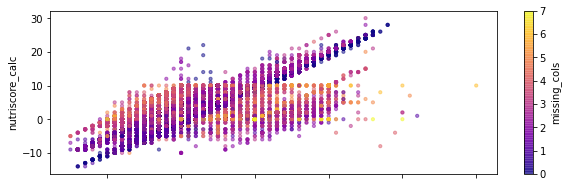

In [270]:
df_n.plot.scatter(x='nutriscore', y='nutriscore_calc', c='missing_cols',
                  s=10, marker='o', alpha=0.5, cmap='plasma')
fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

We notice that errors are quite high even if only one sub_point misses.

We decide to keep only values with 0 missing sub-points.

In [271]:
# Keeping only trustworthy calculated nutriscores to fill missing values in df

df_n['nutriscore_calc_F'] = df_n['nutriscore_calc'].where(df_n['missing_cols']==0)
print("df[nutriscore]'s notna before: ", df['nutriscore'].notna().sum())
df['nutriscore'] = df['nutriscore'].where(df['nutriscore'].notna(),
                                          other=df_n['nutriscore_calc_F'])
print("df[nutriscore]'s notna after: ", df['nutriscore'].notna().sum())

df[nutriscore]'s notna before:  567990
df[nutriscore]'s notna after:  568312


#### _2.7.d Nutrigrade determination_

The nutrigrade is assigned to a product after consideration of :
- its nutriscore
- whether it's solid food or beverage 

In [0]:
## Attribution of a nutrigrade to calculated nutriscores in df_n

# beverages
df_n.loc[i_bev,'nutrigrade_calc'] = pd.cut(df_n.loc[i_bev,'nutriscore_calc'],
                               [-500,1,5,9,500], labels=list('bcde'))
df_n.loc[i_bev,'nutrigrade_calc_F'] = pd.cut(df_n.loc[i_bev,'nutriscore_calc_F'],
                               [-500,1,5,9,500], labels=list('bcde'))
i_wat = df[df['pnns2']=='waters and flavored waters'].index
df_n.loc[i_wat,'nutrigrade_calc'] = 'a'
df_n.loc[i_wat,'nutrigrade_calc_F'] = 'a'
# others
df_n.loc[i_not_bev,'nutrigrade_calc'] = pd.cut(df_n.loc[i_not_bev,'nutriscore_calc'],
                               [-500,-1,2,10,18,500], labels=list('abcde'))
df_n.loc[i_not_bev,'nutrigrade_calc_F'] = pd.cut(df_n.loc[i_not_bev,'nutriscore_calc_F'],
                               [-500,-1,2,10,18,500], labels=list('abcde'))
#unknown (to be sure...)
df_n.loc[i_unkn,'nutrigrade_calc'] = np.nan
df_n.loc[i_unkn,'nutrigrade_calc_F'] = np.nan

In [273]:
# Keeping only trustworthy calculated nutriscores to fill missing values in df

print("df[nutrigrade]'s notna before: ", df['nutrigrade'].notna().sum())
df['nutrigrade'] = df['nutrigrade'].where(df['nutrigrade'].notna(),
                                          other=df_n['nutrigrade_calc_F'])
print("df[nutrigrade]'s notna after: ", df['nutrigrade'].notna().sum())

df[nutrigrade]'s notna before:  570825
df[nutrigrade]'s notna after:  571147


In [0]:
# Dropping columns that won't be used anymore

df = df.drop(columns=['fruit_veg_nut_100g'])

In [275]:
print(df.shape)
print_null_pct(df)

(1386994, 47)
nb of null:  24141781 
pct of null:  37.0


In [276]:
speak('nutriscores cleaned')

## 3 Dealing with duplicates
At first we are going to deal with 'absolute' duplicates (i.e. duplicate on each row). We'll simply keep the first row.

In [0]:
# Function combining all dupl. rows,
# '1st' is the one with highest unique notna val.
''' Among each group of duplicates :
 - finds nb of unique notna for each row
 - selects the one with the most unique notna
 - combines the rows (1st is the selected row)
 - replaces all the rows by combined row
 - returns nb of grps of dupl., indexes of rows to drop, list of rows for update
 '''
def comb_dup_rows(df, cols):
  uniq_notna = lambda x:pd.notna(x.unique()).sum()
  df_f = pd.DataFrame({})
  l_ind = []
  cpt = 0
  for k,df_g in df.groupby(by=cols): # loop on all grps of dup.
    df_comb = pd.DataFrame({})
    ser_gr = df_g.apply(uniq_notna, axis=1) # nb of unique not na values
    idx_max = ser_gr.index[ser_gr.argmax()]
    ind = list(ser_gr.index)
    ind.remove(idx_max)
    df_comb = df_g.loc[idx_max]
    for i in ind: # loop on all dupl. except that with max unique not na
      df_comb = df_comb.combine_first(df_g.loc[i])
    df_f = df_f.append(df_comb)
    l_ind += ind
    cpt += 1
  df_f.reindex(columns=df.columns) #reorder the columns (bug in pd.concat)
  return cpt, l_ind, df_f 

### 3.1 Duplicates on 'code' column

Let's apply this function to df, with the subset ['code'] for the duplicates:

In [278]:
# 1 Keeping the first of duplicates on all columns
print("before", df.shape[0])
df = df[~df.duplicated(keep='first')]
print("after", df.shape[0])

before 1386994
after 1386926


Then, to deal with the duplicates on differents subsets of the columns (['code'] and key_cols), we are going to define a function that combines all the duplicated rows in one. The main row will be the one that has the greater number of unique not null values, and it will be unriched by date from the others rows if available (using pd.DataFrame.combine_first).

In [279]:
# 2 - Checking for duplicates on 'code'
df_dup = df[df.duplicated(subset=['code'],keep=False)]
print("Nb of duplicated rows on 'code':", df_dup.shape[0])

Nb of duplicated rows on 'code': 358


In [280]:
# duplicates on 'code' column
# -> Keeping the 'combined rows', deleting the others
print("Shape of df_dup, before", df_dup.shape[0])
nb_gr, ind_drop, df_dup_f = comb_dup_rows(df_dup, ['code'])
df_dup = df_dup.drop(ind_drop)
df_dup.update(df_dup_f, overwrite=True)
print("Nb of groups of duplicates :", nb_gr)
print("Nb of duplicates :", df_dup.shape[0])
print("Nb of rows to delete:", len(ind_drop))
print("Shape of df_dup, after", df_dup.shape[0])

Shape of df_dup, before 358
Nb of groups of duplicates : 179
Nb of duplicates : 179
Nb of rows to delete: 179
Shape of df_dup, after 179


In [0]:
# Changing df
df = df.drop(ind_drop)
df.update(df_dup_f, overwrite=True)

### 3.2 Duplicates on identification key-columns

Let's apply this function to df, with the subset key_cols for the duplicates:

In [282]:
# 3 - Checking for duplicates on key_cols only
key_cols = ['product_name', 'quantity_num', 'quantity_unit', 'brands_main']
m_dup_keys = df.duplicated(subset=key_cols,keep=False)
m_c_inval = df['code_val']==False
df_dup_k_c_val = df[m_dup_keys & ~m_c_inval]
df_dup_k_c_inval= df[m_dup_keys & m_c_inval]
print(f"Nb of duplicated rows on key_cols with VALID code: {df_dup_k_c_val.shape[0]}" )
print(f"Nb of duplicated rows on key_cols with INVALID code: {df_dup_k_c_inval.shape[0]}")

Nb of duplicated rows on key_cols with VALID code: 358566
Nb of duplicated rows on key_cols with INVALID code: 13201


If there is duplicates with different codes, and at least one of them is valid and one invalid, we want to keep only the rows with valid codes:

In [283]:
# Finding duplicates with at least 1 row with valid code AND 1 invalid code
df_mixed_dup = df[m_dup_keys].groupby(by=key_cols)\
                .filter(lambda x:sum((x['code_val']==True).values)>1\
                        and sum((x['code_val']==False).values)>1)
gb = df_mixed_dup.groupby(by=key_cols)
print(f"Nb of rows with mixed val/inval codes: {sum(gb.size())}")
print(f"Nb of groups of duplicates: {len(gb)}")

Nb of rows with mixed val/inval codes: 12
Nb of groups of duplicates: 2


In [284]:
# shows example of duplicates on key_cols with mixed 'code_val'
gb.get_group(list(gb.groups.keys())[0])

,code,code_val,categories_main,categories_tuple,url,main_category,quantity_unit,quantity_num,serving_quantity,quantity_type,labels_main,labels_tuple,pnns2,pnns1,creator,created_datetime,product_name,countries_main,brands_main,packaging_main,packaging_tuple,brands_tuple,allergens_main,allergens_tuple,countries_tuple,ingredients_text,additives_main,traces_main,traces_tuple,additives_tuple,additives_n,nutriscore,nutrigrade,nova_group,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,energy_from_fat_kj_100g,energy_kj_100g,collagen_meat_protein_ratio_100g
264395,0219968035751,1.00,plant-based food...,(plant-based foo...,http://world-en....,coconut milks,ml,200.00,nan,vol,NaN,"(unknown,)",plant-based milk...,beverages,kiliweb,2018-02-25T11:53...,Lait de coco,france,suzi wan,NaN,"(unknown,)","(suzi wan,)",NaN,"(unknown,)","(france,)",NaN,NaN,NaN,"(unknown,)","(unknown,)",nan,12.00,e,nan,nan,nan,17.00,14.40,1.90,0.60,nan,2.00,0.04,0.02,640.15,707.00,nan
281490,04450300,0.00,plant-based food...,(plant-based foo...,http://world-en....,coconut milks,ml,200.00,nan,vol,NaN,"(unknown,)",plant-based milk...,beverages,kiliweb,2019-04-03T10:48...,Lait de coco,france,suzi wan,NaN,"(unknown,)","(suzi wan,)",NaN,"(unknown,)","(france,)",NaN,NaN,NaN,"(unknown,)","(unknown,)",nan,12.00,e,nan,nan,nan,16.90,14.40,1.90,0.60,nan,2.00,0.04,0.02,636.39,707.00,nan
408312,13782375,1.00,NaN,"(unknown,)",http://world-en....,NaN,ml,200.00,nan,vol,NaN,"(unknown,)",NaN,NaN,kiliweb,2020-02-27T19:28...,Lait de coco,france,suzi wan,NaN,"(unknown,)","(suzi wan, satori)",NaN,"(unknown,)","(france,)",NaN,NaN,NaN,"(unknown,)","(unknown,)",nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
544125,3065890132672,1.00,plant-based food...,(plant-based foo...,http://world-en....,coconut milks,ml,200.00,nan,vol,NaN,"(unknown,)",plant-based milk...,beverages,kiliweb,2017-12-03T14:23...,Lait de coco,france,suzi wan,NaN,"(unknown,)","(suzi wan,)",NaN,"(unknown,)","(france,)",extrait de noix ...,e415 - xanthan gum,NaN,"(unknown,)",(e415 - xanthan ...,1.00,11.00,e,4.00,0.00,0.00,16.90,14.40,1.90,0.60,1.00,2.00,0.40,0.16,636.39,707.00,nan
885473,4002359006715,1.00,plant-based food...,(plant-based foo...,http://world-en....,unsweetened beve...,ml,200.00,50.00,vol,sans exhausteur ...,(sans exhausteur...,plant-based milk...,beverages,openfoodfacts-co...,2017-01-10T19:28...,Lait de coco,france,suzi wan,brique,"(brique, carton,...","(suzi wan,)",NaN,"(unknown,)","(france, italy, ...",extrait de noix ...,e415 - xanthan gum,NaN,"(unknown,)",(e415 - xanthan ...,1.00,10.00,e,4.00,0.00,0.00,17.00,14.40,1.90,0.60,1.00,2.00,0.04,0.02,640.15,707.00,nan
924166,4092350006715,1.00,plant-based food...,(plant-based foo...,http://world-en....,coconut milks,ml,200.00,nan,vol,NaN,"(unknown,)",plant-based milk...,beverages,kiliweb,2018-03-03T15:31...,Lait de coco,france,suzi wan,NaN,"(unknown,)","(suzi wan,)",NaN,"(unknown,)","(france,)",NaN,NaN,NaN,"(unknown,)","(unknown,)",nan,3.00,c,nan,nan,nan,4.25,3.60,1.90,0.60,nan,1.00,0.02,0.01,160.04,180.00,nan
1072005,60663303,0.00,plant-based food...,(plant-based foo...,http://world-en....,coconut milks,ml,200.00,nan,vol,NaN,"(unknown,)",plant-based milk...,beverages,keronos,2015-02-22T10:48...,Lait de coco,france,suzi wan,NaN,"(unknown,)","(suzi wan,)",NaN,"(unknown,)","(france,)",NaN,NaN,NaN,"(unknown,)","(unknown,)",nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1386154,9782035890573,1.00,plant-based food...,(plant-based foo...,http://world-en....,coconut milks,ml,200.00,nan,vol,NaN,"(unknown,)",plant-based milk...,beverages,kiliweb,2019-04-10T15:36...,Lait de coco,france,suzi wan,NaN,"(unknown,)","(suzi wan,)",NaN,"(unknown,)","(france,)",NaN,NaN,NaN,"(unknown,)","(unknown,)",nan,13.00,e,nan,nan,nan,17.50,15.70,2.10,1.80,nan,1.60,0.30,0.12,658.98,724.00,nan


In [285]:
# Dropping the rows with invalid codes in each group
print("Shape of df, before", df.shape[0])
for i in range(len(gb)):
  d = gb.get_group(list(gb.groups.keys())[i])
  ind = d[d['code_val']==False].index
  df.drop(index=ind, inplace=True)
print("Shape of df, after", df.shape[0])

Shape of df, before 1386747
Shape of df, after 1386743


In [286]:
# Refreshing the list
m_dup_keys = df.duplicated(subset=key_cols,keep=False)
m_c_inval = df['code_val']==False
df_dup_k_c_val = df[m_dup_keys & ~m_c_inval]
df_dup_k_c_inval= df[m_dup_keys & m_c_inval]
print(f"Nb of duplicated rows on key_cols with VALID code: {df_dup_k_c_val.shape[0]}" )
print(f"Nb of duplicated rows on key_cols with INVALID code: {df_dup_k_c_inval.shape[0]}")

Nb of duplicated rows on key_cols with VALID code: 358566
Nb of duplicated rows on key_cols with INVALID code: 13197


In [287]:
# Duplicates on key_cols column with invalid codes
# -> Keeping the combined row, deleting the others
print("Shape of df_dup_k_c_inval, before", df_dup_k_c_inval.shape[0])
nb_gr, ind_drop, df_dup_f = comb_dup_rows(df_dup_k_c_inval, key_cols)
df_dup_k_c_inval = df_dup_k_c_inval.drop(ind_drop)
df_dup_k_c_inval.update(df_dup_f, overwrite=True)
print("Nb of groups of duplicates :", nb_gr)
print("Nb of duplicates :", df_dup_k_c_inval.shape[0])
print("Nb of rows to delete:", len(ind_drop))
print("Shape of df_dup_k_c_inval, after", df_dup_k_c_inval.shape[0])

Shape of df_dup_k_c_inval, before 13197
Nb of groups of duplicates : 346
Nb of duplicates : 12881
Nb of rows to delete: 316
Shape of df_dup_k_c_inval, after 12881


In [0]:
# Changing df

df.drop(ind_drop, inplace=True)
df.update(df_dup_k_c_inval, overwrite=True)

In [289]:
print(df.shape)
print_null_pct(df)

(1386427, 47)
nb of null:  24128907 
pct of null:  37.0


In [290]:
speak('duplicates dropped)')

## 4 Dropping inoperable rows

We need to get rid of inoperable rows. We will define operability of a row as follows:

- condition 1: the product can be identified, at least by a unique combination of name, brand and quantity ('product_name', 'quantity', 'brands'), OR by a valid and unique barcode ('code')

AND
- condition 2: at least one numerical 'energy' columns is filled

*Condition 1*:

When the code is not valid, we will check if the product can be identified by a unique combination of "product_name", "quantity" and "brands". (At least one of the three must be filled).

In [291]:
# Dropping rows with invalid codes AND all key_cols NaN
key_cols = ['product_name', 'quantity_num','quantity_unit', 'brands_main']
m_wo_code = df['code_val']==False
m_wo_keys = df[key_cols].isna().all(axis=1)
print("nb of rows before:", df.shape[0])
df.drop(index=df[m_wo_code & m_wo_keys].index, inplace=True)
print("nb of rows after:", df.shape[0])
# original df 1371727 -> 1371166 dup (561) -> 1369244 wrong id (1922)

nb of rows before: 1386427
nb of rows after: 1384290


*Condition 2*:

Let's now check for the second condition that is "energy columns filled", "nutriscore" and "nutrigrade" filled.

In [292]:
# Dropping rows with no nutriscore and no energy

df = df.dropna(subset=['nutriscore', 'nutrigrade', 'energy_kj_100g'],
                       how='any')

df:  (1384290, 47)
df:  (563990, 47)


In [0]:
# Combining data concerning palm oil to make a new column

palm = ['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']
df['ing_from_palm_oil_n'] = df[palm].sum(axis=1)
del df['ingredients_from_palm_oil_n'], df['ingredients_that_may_be_from_palm_oil_n']

In [0]:
# dates to datetime

df['created_datetime'] = pd.to_datetime(df['created_datetime'])
df['created_datetime'] = df['created_datetime'].astype('object')

In [293]:
print(df.shape)
print_null_pct(df)

(563990, 47)
nb of null:  5375941 
pct of null:  20.3


In [294]:
speak('Dropped inoperable rows')

## 5 Imputation of missing values

Let's check missing values after cleaning

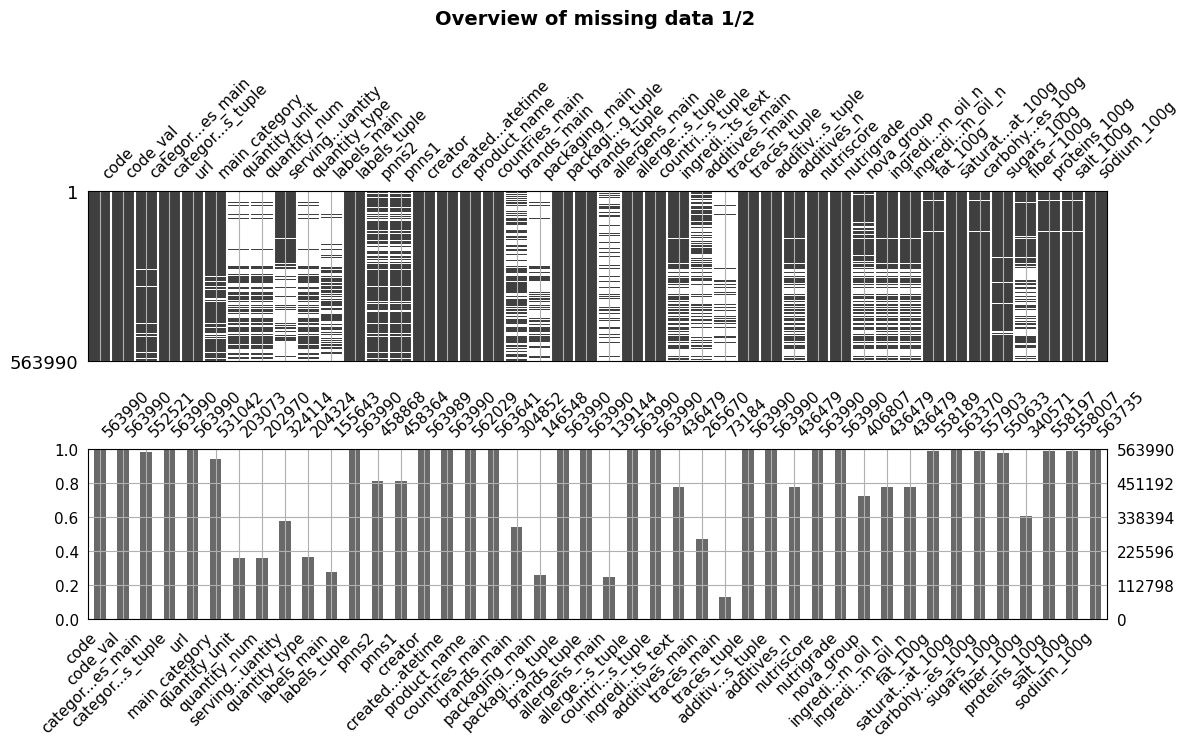

In [295]:
# Displaying number of missing values
cols = df.columns[0:44]
plot_export_missing(df, cols, 'C_5_0_missing_vals.png',
                    'Overview of missing data 1/2', shorten_label=True)

## 5 Exporting cleaned dataframe

In [296]:
# Checking columns in df

print('rows, columns: ',df.shape)
for i, c in enumerate(df.columns):
    print('\n'+c if i % 6 == 0 else c, end=' | ')

rows, columns:  (563990, 47)

code | code_val | categories_main | categories_tuple | url | main_category | 
quantity_unit | quantity_num | serving_quantity | quantity_type | labels_main | labels_tuple | 
pnns2 | pnns1 | creator | created_datetime | product_name | countries_main | 
brands_main | packaging_main | packaging_tuple | brands_tuple | allergens_main | allergens_tuple | 
countries_tuple | ingredients_text | additives_main | traces_main | traces_tuple | additives_tuple | 
additives_n | nutriscore | nutrigrade | nova_group | ingredients_from_palm_oil_n | ingredients_that_may_be_from_palm_oil_n | 
fat_100g | saturated_fat_100g | carbohydrates_100g | sugars_100g | fiber_100g | proteins_100g | 
salt_100g | sodium_100g | energy_from_fat_kj_100g | energy_kj_100g | collagen_meat_protein_ratio_100g | 

In [303]:
print(df.shape)
print_null_pct(df)

(563990, 46)
nb of null:  5120919 
pct of null:  19.7


In [0]:
# # Exporting the dataframe as CSV for further treatment

df.to_csv('OFF_Cleaned.csv')

In [0]:
# Exporting dtypes for optimization of memory usage with pandas

df_type = (df.dtypes).to_frame()
type_to_str = lambda x: re.findall(r'[a-z0-9]+', str(x))[1]
d_types = df_type.apply(type_to_str, axis=1).to_dict()
with open('d_types.json', 'w') as outfile:
    json.dump(d_types, outfile)

In [301]:
''' Code to paste if you want to import easily the cleaned .csv file with dtypes
that optimizes memory usage'''
# make sure d_types.json is in same dir
# f = open('d_types.json', 'r')
# dict_str = f.read()
# d_types = json.loads(dict_str)
# dftest = pd.read_csv('/content/OFF_Cleaned.csv', # change location
#                      dtype=d_types, low_memory=False, encoding ='utf-8')

' Code to paste if you want to import easily the cleaned .csv file with dtypes\nthat optimizes memory usage'

In [0]:
# ''' Exporting requirements file for this notebook if needed'''
# !pip freeze > requirements.txt